In [1]:
import csv
from enum import Enum
import math

# Plotting 
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3

import numpy as np
from numpy.random import PCG64
import time

# import my own libraries
from arm import *               # import the arm state library
from camera import *            # import the simulated vision system
from fruitTreeCreator import *  # import the library that creates the array with fruit location + other info
from scheduler import *         # import the scheduler functions 
from simulation_config import * # import the JSON creation file so that it can be read back to set parameters
from trajectory import *        # import the trajectory generation "library" that I'm writing

import json # configuration file encode and decode
# see https://realpython.com/python-json/#decoding-custom-types

# Testing and Debugging
# Example: https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook
import unittest             # docs https://docs.python.org/3/library/unittest.html 
import pdb #; pdb.set_trace() # docs https://docs.python.org/3/library/pdb.html

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [2]:
######## RANDOM SEED GENERATOR ########
'''Use only when a new seed is needed'''
# https://numpy.org/devdocs/reference/random/index.html

# from numpy.random import PCG64, SeedSequence

# sq1 = np.random.SeedSequence()

# seed = sq1.entropy

# print(seed)

### How to use seeds
## ss = SeedSequence(seed)
## print('seed = {}'.format(ss.entropy))
## bg = PCG64(ss)

######### GENERATED SEEDS ##########
## FRUIT TREE CREATOR SEEDS ##
# self.x_fr - 37428395352013185889194479428694397783 
# self.y_fr - 13250124924871709375127216220749555998
# self.z_fr - 165440185943501291848242755689690423219
# self.x_fake - 264090507119924891834746017829286837587
# self.y_fake - 307175982666302731017951161793326853810
# self.z_fake - 202459549346992037879433717317760015805


'Use only when a new seed is needed'

In [3]:
def step(t, dt):
    t = t + dt
    return t

In [4]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]
        
        poly = Poly3DCollection(verts, closed = False, alpha=0.25)
        poly.set_facecolor("grey")  # the transparency setting (alpha) is overriden by facecolor otherwise
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
    def drawArmCylinder(self, center_y, center_z, arm_start, arm_end):
        # see second answer https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
        radius = 0.2 # set arbitrarily 
        
        x     = np.linspace(arm_start, arm_end, 3)
        theta = np.linspace(0, 2*np.pi, 3)
        
        theta_grid, x_grid = np.meshgrid(theta, x)
        
        y_grid = radius*np.cos(theta_grid) + center_y
        z_grid = radius*np.sin(theta_grid) + center_z
        
        return x_grid,y_grid,z_grid
            

In [5]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [6]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))
        arm     = np.full(len(self.x_fruit), np.inf) # will indicate which arm is set to this goal 

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked, arm])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]


In [7]:
## Set Flag values
class spaceConf(Enum):
    '''Flag values for if the workspace in each row is individual or shared'''
    INDIVIDUAL = 0
    SHARED     = 1
    
    
class calendar(Enum):
    '''Flag values for the type of scheduler to use, name seems like a bad idea :P'''
    SINGLE_FRUIT = 0
    EDF          = 1 # Earliest Deadline First, batch
    

class treeCreation(Enum):
    '''Flags values for the type of data being used as fruit coordinates'''
    CSV_RAJ  = 0
    SYN_LINE = 1
    UNIFORM  = 2
    

class noiseMaker(Enum):
    '''Flags values for the type of noise'''
    TURN_OFF = 0
    TURN_ON  = 1
    
    
class reality(Enum):
    '''Flag values determining how many fruit are real and how many are fake in the simulation'''
    TURN_OFF  = 0
    DENSITY   = 1

In [8]:
###### create JSON configuration file to read from #####
# init function
json_data = simulation_config()

# creates the data file based on default values 
json_data.convertJSON()

# load the json file
data = json.load(open("data.json"))

###### Parameter settings from the JSON configuration file ######

# fruit row depth, in ft  -- x-axis
fruit_row_ed   = data['orchard']['x']['start']  # how far the vehicle will be from the edges of the tree
fruit_row_tk   = data['orchard']['x']['end']    # how far the arms can reach into the canopy/ where the trunk is

# fruit row length, in ft -- y-axis
fruit_row_st   = data['orchard']['y']['start']  
fruit_row_end  = data['orchard']['y']['end'] 

# fruit row height, in ft -- z-axis
fruit_row_bt   = data['orchard']['z']['start']
fruit_row_tp   = data['orchard']['z']['end'] 

# values for fruit density (currently supports only one value overall)
rho_real       = data['orchard']['rho_real']
rho_fake       = data['orchard']['rho_fake']

# decide on the number of arms and rows
num_arms       = data['vehicle']['num_arms']      # set number of arms on robot, will determine the length of the robot (for now)
num_row        = data['vehicle']['num_rows']      # set the number of rows of arms 

# arm's max velocity and acceleration values apparently in ft/s
max_v          = data['arms']['max_v']
max_a          = data['arms']['max_a']

# number of goals the semionline scheduler will look for
n_goals        = data['num_goals']                

# when working with the fruit ribbon, how high above the conveyors will the ribbon be
ribbon_z       = data['ribbon_z']

# decide if the arms are in individual or shared spaces
space_config   = spaceConf(data['space_config'])

# decide on the type of scheduler
appointment    = calendar(data['appointment'])

# decide what fruit distribution to use to create fruit coordinates
data_config    = treeCreation(data['data_config'])

# decide if fake fruit will be added
existance      = reality(data['existance'])

# decide if noise should be added and the distribution
noise_level    = noiseMaker(data['noise_level'])



Would you like to save in seperate file? (y or n)
Invalid answer, default set to not save the file.


In [9]:
####### Vehicle Init Values for parameter setting #######
# configure the vehicle
# make the arm take up space within the space (slowly added)
column_width = 0.2               # width of column holding the arm in place

# calculate the height of the frame based on number of rows, height of orchard, and add column width to make sure all
# fruit can be reached
frame_height = (fruit_row_tp - fruit_row_bt + 2*column_width) / num_row # if the rows are evenly spaced

# configure the arm's space, length added to vehicle per arm in the y-direction
if space_config == spaceConf.INDIVIDUAL:
    frame_width  = 3.                
elif space_config == spaceConf.SHARED:
    frame_width  = 1.9 

width_v  = 1.                    # vehicle width (x-dir, parallel to arms going into canopy) (only for plotting)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

##################### Based on Flags #####################

# initializes required variables based on the distribution creation method
if data_config != treeCreation.CSV_RAJ: 
    q_v = np.array([fruit_row_ed-1.0/2-0.3, fruit_row_st]) 
    v_v = np.array([0.,0.04])  # in ft, constant velocity only in y-axis
    # init a z-coordinate list of where a fruit ribbon will be placed on each row
    fruit_lines = []
    # if using the line distribution, this will set the z height for each line
    for n in range(num_row):
        fruit_lines.append(n*frame_height + ribbon_z) # in ft
        
    # initialize the synthetic fruit distribution creator
    fruit = fruitTreeCreator([fruit_row_st,fruit_row_end]) 
    # settings for an angle offset if the tree data has the fruit set at a diagonal
    arm_offset = 0.
    # create list for fruit and fake fruit 
    fruit_density = []
    fake_density  = []
    
    for n in range(num_row):
        # set fruit density and percent of fake fruit to add (will have to change later to add sections
        # with different densities)
        fruit_density.append([rho_real])  # in fruit/ft^3 (unless using LINE, then it's fruit/ft^2)
        if existance == reality.DENSITY:
            fake_density.append([rho_fake])
        else:
            fake_density.append([0.0])

    
elif data_config == treeCreation.CSV_RAJ:
    q_v = np.array([4.5,7.]) # fruits are in very specific locations
    # CSV fruit are diagonally placed (fix that later?)
    v_v = np.array([0.01,0.05])  # in ft, constant velocity   => for single fruit got almost 100% fruit at 0.007m/s with 0.73s/fruit (too slow)
    # use Raj's digitized fruit from real trees
    fruit = csvRead()  
    # settings for an angle offset if the tree data has the fruit set at a diagonal
    arm_offset = 0.75 / (num_row-1)

    
    
if data_config == treeCreation.SYN_LINE:  
    # create synthetic fruit data in a line to test the robot when fruit are set at one specific height
    for r in range(num_row):
        fruit.fruitLine(num_row, fruit_density[r], [fruit_row_ed,fruit_row_tk], fruit_lines[r], fake_density[r])
#     fruit.fruitLine(fruit_lines)
    fruit.fruitTreeOut()
    
elif data_config == treeCreation.UNIFORM:
    # test the robot when there is variation in distance between fruit
#     fruit.fruitUniform()
    for r in range(num_row):
        fruit.fruitUniform(num_row,fruit_density[r],[fruit_row_ed,fruit_row_tk],[fruit_row_bt,fruit_row_tp], fake_density[r])
    fruit.fruitTreeOut()
        
    

In [10]:
####################### init vehicle lists for data analysis #######################
# used to plot the vehicle
qv0 = []
qv1 = []

##################### init environment #####################
# end of the row (when the back of vehicle reaches this point it should stop)
end_row = fruit_row_end + width_v
t       = []         # 'global' time
t_step  = 0.
dt      = 0.01      # 'global' time step size
runs    = 0

# used to plot basic outlines of the robot for better visualization
dr = drawRobot()

# create empty list which will save arm states for plotting and data processing
arm_states = [] 

######################## init camera #######################
row_picture = []

for rows in range(num_row): # one "camera" object per row on vehicle
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
    
######################### init arms ########################

# array of arm object setup
a = np.ndarray((num_row,num_arms), dtype=object) 

# setup for arm initialization
arm0start_y = q_v[1] - (length_v - frame_width)/2  # arm starting position in the y-dir
q_a_new = np.array([0.,0.,0.])                     # used as a temporary value while calculating arm init positions
            
# initialize the arm objects in a matrix set for each row and for the number of arms in  said row
for rows in range(num_row):       
    for count in range(num_arms):      
        # calculate where each new arm should go
        # if fruit's in a diagonal, get the bottom arms closer to the fruit
        # the 0.3 is the zero starting point since it will never be exactly zero if they're extending cylinders
        q_a_new[0] = q_v[0] + 0.3 + ((num_row-1)*arm_offset - arm_offset*rows)
        q_a_new[1] = arm0start_y + frame_width*count # places the arms either in their space or far from each other
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # last one this makes sure it matches the "camera" object's z-location         
        
        # initialize the new arm
        x = arm(q_a_new, q_v, count, num_arms, frame_width, frame_height, column_width, rows, max_v, max_a, space_config.value)
        # add the arm to the a-list     
        a[rows,count] = x

# for plotting data
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


###################### init scheduler ######################
goal = np.zeros(3) # does this go here? it's an empty array for the goal values for each arm...

s = scheduler(n_goals, num_row, num_arms, max_v, max_a) 
# make a scheduler function that sets n_goals only if it's synthetic data

In [11]:
### MAIN LOOP CODE ###

## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_step = step(t_step, dt)
    t.append(float(t_step))    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    for rows in range(num_row):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise_level == noiseMaker.TURN_ON):
        # add some noissse! (to the fruit locations)
        noise_level = noiseMaker.TURN_OFF # but not right now
        
    # scheduler setting
    if appointment == calendar.SINGLE_FRUIT:
        s.singleFruitScheduler(num_row, num_arms, a, row_picture, fruit)
        
    elif appointment == calendar.EDF:
        if runs % 100 == 0: # don't want to run the scheduler every millisecond
            s.edfScheduler(a, row_picture, fruit, v_v, space_config.value) 
        # go through the list and give each arm a goal
        for rows in range(num_row):
            # give each free arm in that row a goal
                for arm_free in range(num_arms):
                    if a[rows,arm_free].free == 1:
                        # need to check if there are goals
                        if (not s.goal_queue[rows, arm_free].empty()):
                            goal_new = s.goal_queue[rows, arm_free].get()
                            # give the arm the index so that it can set it back to 0 if it does not reach it
                            a[rows,arm_free].goal_index = goal_new
                            # set the new goal
                            a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_step) 

    
    # have each arm take a step
    for rows in range(num_row):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, a[rows,:], dt, t_step, fruit, row_picture)
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(q_v[0]))  # set at the center of the vehicle in case the arm is set as diagonal to rach farther fruit
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
    
    arm_index = 0
    arm_list  = []
    
    # compile at which state each arm ends the loop to add to plot later
    for rows in range(num_row):
        for arm2state in range(num_arms):
            arm_list.append([arm_index, a[rows, arm2state].stateFLAG])
            arm_index += 1
    
    # save arm states 
    arm_states.append(arm_list)
               
    runs+=1


prog_time = time.time() - start_time

start, end, start velocity: -0.2 0.988814429908131 0.0
start, end, start velocity: 1.9000000000000001 0.0015401856941155145 0.0
start, end, start velocity: 1.175 0.6442726013808399 0.0
start, end, start velocity: 0.988814429908131 -0.2 0.0
start, end, start velocity: 0.6442726013808399 0.0 0.0
start, end, start velocity: -0.2 1.0705508498659766 0.0
start, end, start velocity: 2.220446049250313e-16 0.07059252397484395 0.0
start, end, start velocity: 1.175 1.448549770617991 0.0
start, end, start velocity: 1.0705508498659766 -0.2 0.0
start, end, start velocity: 1.448549770617991 0.0 0.0
start, end, start velocity: -0.2 0.7134600028870357 0.0
start, end, start velocity: -1.8999999999999997 0.09347548702352548 0.0
start, end, start velocity: 1.175 0.09331199847688876 0.0
start, end, start velocity: 0.7134600028870357 -0.2 0.0
start, end, start velocity: 0.09331199847688876 0.0 0.0
start, end, start velocity: -0.2 0.33254442725355443 0.0
start, end, start velocity: 0.0015401856941155145 0.23

start, end, start velocity: -0.2 1.0241605210286384 0.0
start, end, start velocity: 1.9000000000000001 0.3883892465528671 0.0
start, end, start velocity: 1.175 1.3452601355448774 0.0
start, end, start velocity: -0.2 0.945867392517139 0.0
start, end, start velocity: 1.9000000000000001 0.39138471463149305 0.0
start, end, start velocity: 3.5250000000000004 3.4033983214419017 0.0
start, end, start velocity: -0.2 1.1793898283433508 0.0
start, end, start velocity: 1.9000000000000001 0.5006525831360686 0.0
start, end, start velocity: 5.875 5.842721279987345 0.0
start, end, start velocity: -0.2 0.3240905580098938 0.0
start, end, start velocity: 1.9000000000000001 0.44506045419106244 0.0
start, end, start velocity: 8.225000000000001 8.344168791424288 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.7034945713468113 0.0
start, end, start velocity: 1.7249999999999994 0.6736073096466094 0.0
start, end, start velocity: 3.4033983214419026 3.5287049370222485 0.0
**

start, end, start velocity: -0.2 1.106164318903287 0.0
start, end, start velocity: 0.6932477206364541 0.9646334273876844 0.0
start, end, start velocity: 4.7 5.176421479302177 0.0
start, end, start velocity: 0.33112924772158425 0.0 0.0
start, end, start velocity: -0.2 1.248768407933656 0.0
start, end, start velocity: 0.4347034020391264 0.7753113757368341 0.0
start, end, start velocity: 7.050000000000002 8.227646545482388 0.0
start, end, start velocity: -0.2 1.0466046638488198 0.0
start, end, start velocity: 0.502809534610208 0.7709214427451511 0.0
start, end, start velocity: 0.0 1.8387775065352523 0.0
start, end, start velocity: 0.17589857604012585 0.0 0.0
start, end, start velocity: -0.2 0.32371733455506796 0.0
start, end, start velocity: 0.10989522470232833 0.16697673967069893 0.0
start, end, start velocity: 4.7 6.692704099882332 0.0
start, end, start velocity: -0.2 1.060456258535161 0.0
start, end, start velocity: 1.3768334507130575 1.620552302362449 0.0
start, end, start velocity: 7

start, end, start velocity: 7.703181559129633 7.050000000000002 0.0
start, end, start velocity: 0.7410346772013959 -0.2 0
start, end, start velocity: 1.8387775065352927 0.0 0.0
start, end, start velocity: 1.594161364233623 0.0 0.0
start, end, start velocity: 5.3666067936232364 4.7 0.0
start, end, start velocity: 1.037113207540253 -0.2 0
start, end, start velocity: 0.6130101636642459 -0.2 0
start, end, start velocity: -0.2 1.1115253690798002 0.0
start, end, start velocity: 1.2006727824439782 1.4044679832522027 0.0
start, end, start velocity: 7.050000000000002 8.816597352867943 0.0
start, end, start velocity: -0.2 0.5779715875328761 0.0
start, end, start velocity: 0.8264556476468282 1.3080014403903495 0.0
start, end, start velocity: 7.050000000000002 8.187305114468227 0.0
start, end, start velocity: -0.2 1.1837583995834748 0.0
start, end, start velocity: 0.2507789201782022 0.48255962695356314 0.0
start, end, start velocity: 4.7 4.935954757304803 0.0
start, end, start velocity: -0.2 0.766

start, end, start velocity: 0.9752257243461269 -0.2 0
start, end, start velocity: 6.509887021745526 4.7 0.0
start, end, start velocity: 0.6024247393669924 -0.2 0
start, end, start velocity: -0.1999999999999312 1.2780474927685088 0.0
start, end, start velocity: 2.5620918978878495 2.424814795684535 0.0
start, end, start velocity: 0.16057443993166948 2.2942332360912 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.1999999999999312 0.5830638161262494 0.0
start, end, start velocity: 2.565725106064942 2.8773057633423442 0.0
start, end, start velocity: 0.16057443993166948 1.2414949606190482 0.0
start, end, start velocity: -0.19999999999981627 1.2139785664412797 0.0
start, end, start velocity: 3.002158147581179 3.2699355993198926 0.0
start, end, start velocity: 7.845000000000196 7.464392826020619 0.0
start, end, start velocity: 1.2139785664412797 -0.19999999999981627 0.0
start, end, start velocity: 7.464392826020619 7.050000000000002 0.0
start, end, start veloci

start, end, start velocity: -0.19999999999988144 1.2706232658386056 0.0
start, end, start velocity: 1.5066926488252914 1.610811230994491 0.0
start, end, start velocity: 1.571790657697858e-13 0.17022603828315153 0.0
start, end, start velocity: 1.0887054199550699 0.0 0.0
start, end, start velocity: 3.2315063953349448 2.3500000000000005 0.0
start, end, start velocity: 0.5830638161261261 -0.2 0
start, end, start velocity: 3.163919719682398 2.3500000000000005 0.0
start, end, start velocity: 7.663916059021939 7.050000000000002 0.0
start, end, start velocity: 1.1594946471707994 -0.2 0
start, end, start velocity: -0.11193618387388124 1.0839318987993167 0.0
start, end, start velocity: 2.877342887776371 3.3730052253838796 0.0
start, end, start velocity: 1.2414949606188783 1.9404967072260912 0.0
start, end, start velocity: 1.0839318987993167 -0.11193618387388124 0.0
start, end, start velocity: 1.9404967072260912 0.0 0.0
start, end, start velocity: -0.19999999999986134 0.9867435513515699 0.0
start

start, end, start velocity: -0.1999999999998364 0.5095473730512909 0.0
start, end, start velocity: 1.5467042034624885 1.93443286759169 0.0
start, end, start velocity: 4.700000000000414 5.105908267275134 0.0
start, end, start velocity: 1.0081997282241584 0.0 0.0
start, end, start velocity: 2.9651885279233516 2.3500000000000005 0.0
start, end, start velocity: -0.1999999999998535 1.2237014486315532 0.0
start, end, start velocity: 2.597438539064095 3.0440120150080436 0.0
start, end, start velocity: 2.4732407961913783e-13 1.0662092073385132 0.0
start, end, start velocity: -0.19999999999985046 1.270117502191937 0.0
start, end, start velocity: 2.377005586719604 0.10077153263535477 0.0
start, end, start velocity: 7.050000000000319 8.991560990118277 0.0
start, end, start velocity: 0.8236239998749277 -0.2 0
start, end, start velocity: -0.19999999999978355 0.4179663787806362 0.0
start, end, start velocity: 2.936505079810865 2.9384660651126744 0.0
start, end, start velocity: 2.3500000000002617 2.3

start, end, start velocity: -0.2 0.9800640162066425 0.0
start, end, start velocity: 3.09081201500796 3.34654349324196 0.0
start, end, start velocity: 0.0 0.42101531503913014 0.0
start, end, start velocity: 0.49546370392350225 -0.2 0
start, end, start velocity: -0.2 0.3702518972750863 0.0
start, end, start velocity: 3.5468995492601945 3.6664535172642845 0.0
start, end, start velocity: 2.3500000000000005 4.098315494000212 0.0
start, end, start velocity: 0.7578287459302154 -0.2 0
start, end, start velocity: 8.991560990118009 7.050000000000002 0.0
start, end, start velocity: 0.3418721725157401 -0.2 0
start, end, start velocity: 1.9404967072261625 0.0 0.0
start, end, start velocity: 1.2010094229457575 -0.2 0
start, end, start velocity: 5.90714049558962 4.7 0.0
start, end, start velocity: 0.6377903156744081 0.0 0.0
start, end, start velocity: 5.419169273267541 4.7 0.0
start, end, start velocity: 7.770497690084817 7.050000000000002 0.0
start, end, start velocity: 4.416095580579094 2.350000000

start, end, start velocity: -0.2 0.4656841580903324 0.0
start, end, start velocity: 3.8529593676957474 3.862559367695659 0.0
start, end, start velocity: 1.8441654755214911 1.8441654755211236 0.0
start, end, start velocity: 1.1191012169217625 -0.2 0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: 5.850281439601596 4.7 0.0
start, end, start velocity: 1.2701175021922304 -0.2 0
start, end, start velocity: -0.2 0.5260957721046444 0.0
start, end, start velocity: 1.5793978089632457 2.0911003635876475 0.0
start, end, start velocity: 4.7 6.278999485861821 0.0
start, end, start velocity: -0.2 0.4495722371582835 0.0
start, end, start velocity: 0.1758720356009176 0.20757537346273447 0.0
start, end, start velocity: 2.3500000000000005 4.588762015993937 0.0
start, end, start velocity: 0.46568415809046393 -0.2 0
start, end, start velocity: 0.9655751615906644 -0.2 0
start, end, start velocity: -0.2 0.5988311086430405 0.0
start, end, start velocity: 2.4947141426678887 3.0319889

start, end, start velocity: 0.598645407747889 -0.2 0
start, end, start velocity: 4.998245470634154 4.7 0.0
start, end, start velocity: 8.344168791424519 7.050000000000002 0.0
start, end, start velocity: -0.2 1.2386629644603953 0.0
start, end, start velocity: 0.3010388962065649 0.4452345783449968 0.0
start, end, start velocity: 2.3500000000000005 2.442079642715966 0.0
start, end, start velocity: -0.2 0.46764521003050924 0.0
start, end, start velocity: 3.2841806649405307 3.2829981733656948 0.0
start, end, start velocity: 4.7 5.30423322351944 0.0
start, end, start velocity: -0.2 0.4635533603260809 0.0
start, end, start velocity: 4.409999999999784 4.370814753996902 0.0
start, end, start velocity: 7.5349999999999815 8.166995956601976 0.0
start, end, start velocity: 0.4635533603260809 -0.2 0.0
start, end, start velocity: 8.166995956601976 7.050000000000002 0.0
start, end, start velocity: -0.2 0.9301467788527811 0.0
start, end, start velocity: 3.9231999999998157 4.061075409011295 0.0
start, e

start, end, start velocity: -0.2 1.159494647171011 0.0
start, end, start velocity: 0.07306330018117425 3.002158147581249 0.0
start, end, start velocity: 7.050000000000002 8.732320423895285 0.0
start, end, start velocity: 7.338220858102011 7.050000000000002 0.0
start, end, start velocity: 0.2159039186007642 0.0 0.0
start, end, start velocity: 2.9794419923855813 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.988814429908131 0.0
start, end, start velocity: 0.6290557867368 0.0015401856941155145 0.0
start, end, start velocity: 0.0 0.6442726013808399 0.0
start, end, start velocity: 1.1214898992145346 -0.2 0
start, end, start velocity: 0.8217556943737613 -0.2 0
start, end, start velocity: 1.1097499181847506 -0.2 0
start, end, start velocity: -0.2 0.6338744455207139 0.0
start, end, start velocity: 4.706069031165759 4.95843470209271 0.0
start, end, start velocity: 0.0 0.49595258990083746 0.0
start, end, start velocity: 0.6338744455207139 -0.2 0.0
start, end, start velocity: 0.4959525

start, end, start velocity: 4.066819088569287 2.3500000000000005 0.0
start, end, start velocity: 0.336955028791704 -0.2 0
start, end, start velocity: 0.39959160324172516 -0.2 0
start, end, start velocity: 0.9900025138012841 -0.2 0
start, end, start velocity: -0.1999999999995707 1.2784350127166066 0.0
start, end, start velocity: 5.356646068222088 5.35983038102347 0.0
start, end, start velocity: 2.5553409215006706e-13 1.302208370557154 0.0
start, end, start velocity: 0.22459160324170202 1.2526317151181408 0.0
start, end, start velocity: 5.096046068222094 5.423582500859448 0.0
start, end, start velocity: 0.8530534651122152 1.2119149251726815 0.0
start, end, start velocity: 1.2526317151181408 0.22459160324170202 0.0
start, end, start velocity: 1.2119149251726815 0.0 0.0
start, end, start velocity: -0.19999999999939197 0.41373701814478786 0.0
start, end, start velocity: 3.2851197344820386 5.4394543183183375 0.0
start, end, start velocity: 1.245000000000111 0.7874893841223443 0.0
start, end,

start, end, start velocity: 0.3133279417284568 -0.2 0
start, end, start velocity: -0.19999999999928458 1.1233571858183238 0.0
start, end, start velocity: 5.312386657174376 5.2942845054840095 0.0
start, end, start velocity: 4.700000000001213 6.893855793616276 0.0
start, end, start velocity: 0.8321253524454346 -0.2 0
start, end, start velocity: 2.6292366504928477 2.3500000000000005 0.0
start, end, start velocity: -0.1999999999992335 0.988814429908131 0.0
start, end, start velocity: 3.9142509055604515 0.0015401856941155145 0.0
start, end, start velocity: 1.1803546421523814e-12 0.6442726013808399 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.1999999999992335 0.3899459544884388 0.0
start, end, start velocity: 3.9142509055604515 5.12629585750396 0.0
start, end, start velocity: 1.1803546421523814e-12 1.2561519510401633 0.0
start, end, start velocity: -0.1999999999997341 1.0423496841478679 0.0
start, end, start velocity: 4.887135786992393 5.1657146010518185 0

start, end, start velocity: -0.19999999999958604 0.8806429695428113 0.0
start, end, start velocity: 5.760990591194883 5.877296564887616 0.0
start, end, start velocity: 4.700000000000569 6.202756668531453 0.0
start, end, start velocity: 0.8806429695428113 -0.19999999999958604 0.0
start, end, start velocity: 6.202756668531453 4.7 0.0
start, end, start velocity: 0.5650000000003403 0.7849797694430798 0.0
start, end, start velocity: 5.3782200981034265 6.123540138208478 0.0
start, end, start velocity: 5.945137384064247 6.305072792630488 0.0
start, end, start velocity: 0.7849797694430798 0.5650000000003403 0.0
start, end, start velocity: 6.305072792630488 4.7 0.0
start, end, start velocity: 0.1493927242445381 0.6305186543164998 0.0
start, end, start velocity: 3.5308336408349037 6.216037752965492 0.0
start, end, start velocity: 5.013198926823532 5.0893524382782855 0.0
start, end, start velocity: 0.6305186543164998 0.1493927242445381 0.0
start, end, start velocity: 5.0893524382782855 4.7 0.0
st

start, end, start velocity: 1.1448111473101132 -0.2 0
start, end, start velocity: 0.6822414227737618 -0.2 0
start, end, start velocity: -0.19999999999932033 0.7849797694430798 0.0
start, end, start velocity: 5.386284505484071 6.123540138208478 0.0
start, end, start velocity: 4.700000000001171 6.305072792630488 0.0
start, end, start velocity: 0.6849398739027502 0.0 0.0
start, end, start velocity: -0.1999999999992744 0.4190996151313598 0.0
start, end, start velocity: 6.330799999999573 6.35020282650782 0.0
start, end, start velocity: 2.3501072470772044 4.08553668699943 0.0
start, end, start velocity: 0.4190996151313598 -0.1999999999992744 0.0
start, end, start velocity: 4.08553668699943 2.3500000000000005 0.0
start, end, start velocity: -0.1999999999993612 0.7072864501087872 0.0
start, end, start velocity: 6.025199999999584 6.398767644849637 0.0
start, end, start velocity: 2.5776667218837934 4.600031553165503 0.0
start, end, start velocity: 0.7072864501087872 -0.1999999999993612 0.0
start

start, end, start velocity: 1.295921182895035 -0.2 0
start, end, start velocity: -0.19999999999949408 0.4943550418819695 0.0
start, end, start velocity: 6.38759467073016 6.479886845514427 0.0
start, end, start velocity: 6.1182199563258886 6.118219956326643 0.0
start, end, start velocity: 0.6966190900204466 0.0 0.0
start, end, start velocity: 0.5457839578100424 -0.2 0
start, end, start velocity: 6.519673035967879 4.7 0.0
start, end, start velocity: -0.199999999999683 1.250860870732799 0.0
start, end, start velocity: 6.610438911681479 6.730047334246151 0.0
start, end, start velocity: 2.350000000000926 4.562200047252274 0.0
start, end, start velocity: 1.250860870732799 -0.199999999999683 0.0
start, end, start velocity: 4.562200047252274 2.3500000000000005 0.0
start, end, start velocity: -0.1999999999993612 0.6376711835211004 0.0
start, end, start velocity: 6.025199999999584 6.91424050399797 0.0
start, end, start velocity: 2.5776667218837934 3.7933348624960237 0.0
start, end, start velocit

start, end, start velocity: 6.9739707562086135 6.118395666858001 0.0
start, end, start velocity: 7.050000000000002 7.078904036052674 0.0
start, end, start velocity: 1.2850341884375946 -0.1999999999993663 0.0
start, end, start velocity: 7.078904036052674 7.050000000000002 0.0
start, end, start velocity: -0.19999999999931012 0.6705409960666899 0.0
start, end, start velocity: 5.7515932883517085 5.846879189492565 0.0
start, end, start velocity: 7.050000000000002 7.667219512375172 0.0
start, end, start velocity: 0.6705409960666899 -0.19999999999931012 0.0
start, end, start velocity: 7.667219512375172 7.050000000000002 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.19999999999931012 0.9651403660503459 0.0
start, end, start velocity: 5.846879189492565 5.894861236964669 0.0
start, end, start velocity: 7.050000000000002 8.410524392153196 0.0
start, end, start velocity: 0.9651403660503459 -0.19999

start, end, start velocity: 5.0893524382780795 4.7 0.0
start, end, start velocity: -0.19999999999940216 0.3016511920698664 0.0
start, end, start velocity: 7.12368711508529 7.309657640089274 0.0
start, end, start velocity: 2.3500000000006223 4.032181216487246 0.0
start, end, start velocity: 0.3016511920698664 -0.19999999999940216 0.0
start, end, start velocity: 4.032181216487246 2.3500000000000005 0.0
start, end, start velocity: -0.1999999999993612 0.6923108599260275 0.0
start, end, start velocity: 6.025199999999584 7.509536986738913 0.0
start, end, start velocity: 2.5776667218837934 3.802415846337566 0.0
start, end, start velocity: 0.6923108599260275 -0.1999999999993612 0.0
start, end, start velocity: 3.802415846337566 2.3500000000000005 0.0
start, end, start velocity: -0.199999999999443 0.4717884703867848 0.0
start, end, start velocity: 5.823599999999584 7.689530835520849 0.0
start, end, start velocity: 2.619908088535066 3.193046852487808 0.0
start, end, start velocity: 0.471788470386

start, end, start velocity: 0.4128467103932212 -0.2 0
start, end, start velocity: -0.2 0.8606549549377611 0.0
start, end, start velocity: 7.118440875376357 7.592270434345832 0.0
start, end, start velocity: 4.7 4.767500723329877 0.0
start, end, start velocity: 2.245327482574383 0.0 0.0
start, end, start velocity: -0.2 0.8606549549377611 0.0
start, end, start velocity: 7.39438295589641 7.592270434345832 0.0
start, end, start velocity: 4.7674541181266825 4.767500723329877 0.0
start, end, start velocity: 1.1861906238253845 -0.2 0
start, end, start velocity: -0.2 0.6277026197821913 0.0
start, end, start velocity: 7.40558439347755 7.663314425431772 0.0
start, end, start velocity: 0.0 0.6576731088886185 0.0
start, end, start velocity: 3.5328282794366523 2.3500000000000005 0.0
start, end, start velocity: 0.39499999999995017 0.631438263796694 0.0
start, end, start velocity: 7.663314425431995 7.90910549745368 0.0
start, end, start velocity: 0.6576731088892102 0.8788639426582511 0.0
start, end, s

start, end, start velocity: -0.1900000000000091 1.138396905352928 0.0
start, end, start velocity: 8.198221489524352 8.333418437359086 0.0
start, end, start velocity: 6.178091280577568 4.736338650979063 0.0
start, end, start velocity: 1.138396905352928 -0.1900000000000091 0.0
start, end, start velocity: 4.736338650979063 4.7 0.0
start, end, start velocity: -0.19999999999949408 0.9097326220350166 0.0
start, end, start velocity: 7.60639999999941 8.3463943335909 0.0
start, end, start velocity: 5.50599365296016 6.0159483339493605 0.0
start, end, start velocity: 0.9097326220350166 -0.19999999999949408 0.0
start, end, start velocity: 6.0159483339493605 4.7 0.0
start, end, start velocity: -0.2 1.0877806429432666 0.0
start, end, start velocity: 7.405988747844378 8.483083394395848 0.0
start, end, start velocity: 4.7674541181266825 4.952144690427646 0.0
start, end, start velocity: 1.0877806429432666 -0.2 0.0
start, end, start velocity: 4.952144690427646 4.7 0.0
start, end, start velocity: 1.22372

start, end, start velocity: 0.501150692081291 -0.2 0
start, end, start velocity: 1.0845994231024532 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement *

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 1.1144595714512513 -0.2 0
start, end, start velocity: 1.0766042465091594 -0.2 0
start, end, start velocity: 2.05900277205022 0.0 0.0
start, end, start velocity: 2.3572665755994264 2.3500000000000005 0.0
start, end, start velocity: -0.2 1.2914348060203154 0.0
start, end, start velocity: 9.305731381309101 9.45961280664891 0.0
start, end, start velocity: 4.7 6.335936805399905 0.0
start, end, start velocity: 1.2914348060203154 -0.2 0.0
start, end, start velocity: 6.335936805399905 4.7 0.0
start, end, start velocity: -0.19999999999949408 0.5417221752576136 0.0
start, end, start velocity: 7.60639999999941 9.497322889836482 0.0
start, end, start velocity: 5.50599365296016 6.363964053204547 0.0
start, end, start velocity: 0.5417221752576136 -0.19999999999949408 0.0
start, end, start velocity: 6.363964053204547 4.7 0.0
start, end, start velocity: -0.2 0.7375959134405403 0.0
start, end, start velocity: 7.405988747844378 9.516862408046414 0.0
start, end, start velocity

start, end, start velocity: 3.1003095367297826 2.3500000000000005 0.0
start, end, start velocity: 2.2777718295646285 0.0 0.0
start, end, start velocity: 0.3209841037096456 -0.2 0
start, end, start velocity: 5.715968344685574 4.7 0.0
start, end, start velocity: -0.2 1.0638938828812656 0.0
start, end, start velocity: 9.682566315044154 9.843454965342174 0.0
start, end, start velocity: 0.0 0.4890971720679562 0.0
start, end, start velocity: -0.2 0.5448340063644954 0.0
start, end, start velocity: 9.576995783249096 9.823114168830651 0.0
start, end, start velocity: 4.7 5.2766258144011156 0.0
start, end, start velocity: 0.5448340063651688 -0.2 0
start, end, start velocity: 1.063893882882412 -0.2 0
start, end, start velocity: 5.276625814401624 4.7 0.0
start, end, start velocity: -0.19822122342441778 0.7363662018298016 0.0
start, end, start velocity: 9.843454965342344 10.03151559257312 0.0
start, end, start velocity: 0.489097172068393 0.8049735157675828 0.0
start, end, start velocity: 0.736366201

start, end, start velocity: 1.009003917096329 -0.2 0
start, end, start velocity: 0.41547660371751116 0.0 0.0
start, end, start velocity: 0.7994959847114266 -0.2 0
start, end, start velocity: 0.9472086339765583 -0.2 0
start, end, start velocity: 6.4402337895359905 4.7 0.0
start, end, start velocity: 3.8481112356191565 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.8266259486520504 0.0
start, end, start velocity: 10.279101904566703 10.451558742325798 0.0
start, end, start velocity: 3.533111235619212 4.475912734257995 0.0
start, end, start velocity: 0.8266259486520504 -0.2 0.0
start, end, start velocity: 4.475912734257995 2.3500000000000005 0.0
start, end, start velocity: -0.1999999999993612 0.4147531001738049 0.0
start, end, start velocity: 6.025199999999584 10.71632300391373 0.0
start, end, start velocity: 2.5776667218837934 4.442257075525457 0.0
start, end, start velocity: 0.4147531001738049 -0.1999999999993612 0.0
start, end, start velocity: 4.442257075525457 2.350000000000

start, end, start velocity: -0.2 0.4947874248051332 0.0
start, end, start velocity: 10.693958742326435 10.940562390858787 0.0
start, end, start velocity: 2.3500000000000005 3.6239534610149877 0.0
start, end, start velocity: 0.4947874248051332 -0.2 0.0
start, end, start velocity: 3.6239534610149877 2.3500000000000005 0.0
start, end, start velocity: -0.1999999999993612 0.966091601611716 0.0
start, end, start velocity: 6.025199999999584 10.962756481097466 0.0
start, end, start velocity: 2.5776667218837934 2.930755043444603 0.0
start, end, start velocity: 0.966091601611716 -0.1999999999993612 0.0
start, end, start velocity: 2.930755043444603 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.4947874248051332 0.0
start, end, start velocity: 10.693958742326435 10.940562390858787 0.0
start, end, start velocity: 2.3500000000000005 3.6239534610149877 0.0
start, end, start velocity: 0.6397415796644025 0.0 0.0
start, end, start velocity: -0.2 -0.2 0
start, end, start velocity: -0.2 0.98122

start, end, start velocity: 8.364752394914488 7.050000000000002 0.0
start, end, start velocity: -0.2 0.4389290029095228 0.0
start, end, start velocity: 11.434840358740407 11.572658806457131 0.0
start, end, start velocity: 0.0 2.266011167812101 0.0
start, end, start velocity: 0.4389290029095228 -0.2 0.0
start, end, start velocity: 2.266011167812101 0.0 0.0
start, end, start velocity: -0.19999999999969326 0.5073729375141685 0.0
start, end, start velocity: 7.453500548981487 11.584206352455514 0.0
start, end, start velocity: 0.18748375071074708 1.8439330000871132 0.0
start, end, start velocity: 0.5073729375141685 -0.19999999999969326 0.0
start, end, start velocity: 1.8439330000871132 0.0 0.0
start, end, start velocity: -0.2 0.7558736737995022 0.0
start, end, start velocity: 7.078624219178588 6.653410561299353 0.0
start, end, start velocity: 2.199302354797402 1.4649659495722098 0.0
start, end, start velocity: 0.7558736737995022 -0.2 0.0
start, end, start velocity: 1.4649659495722098 0.0 0.0

start, end, start velocity: 0.43892900291009596 -0.2 0
start, end, start velocity: -0.2 1.147255760292446 0.0
start, end, start velocity: 6.649199999999107 6.9739707562086135 0.0
start, end, start velocity: 7.050000000000002 8.446757305070877 0.0
start, end, start velocity: 0.5188297691253116 -0.2 0
start, end, start velocity: 1.1443090293637643 -0.2 0
start, end, start velocity: 4.185230012825256 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.3074571834467203 0.0
start, end, start velocity: 11.5851788206779 11.58249711337182 0.0
start, end, start velocity: 2.3500000000000005 2.6788550998021354 0.0
start, end, start velocity: 2.266011167814153 0.0 0.0
start, end, start velocity: -0.19999999999931012 -0.2 0
start, end, start velocity: -0.19999999999931012 0.693883016505074 0.0
start, end, start velocity: 6.483599999999103 6.658414449802269 0.0
start, end, start velocity: 7.08250372796674 7.915725860706981 0.0
start, end, start velocity: 6.167337495069348 4.7 0.0
start, end, s

start, end, start velocity: 1.1472557602936655 -0.2 0
start, end, start velocity: -0.2 0.8114535591909748 0.0
start, end, start velocity: 11.717872503080143 11.886398844089962 0.0
start, end, start velocity: 4.7 6.872518851555704 0.0
start, end, start velocity: 0.8114535591909748 -0.2 0.0
start, end, start velocity: 6.872518851555704 4.7 0.0
start, end, start velocity: -0.19999999999949408 0.4919099084338043 0.0
start, end, start velocity: 7.60639999999941 11.951949500472029 0.0
start, end, start velocity: 5.50599365296016 5.63649405931203 0.0
start, end, start velocity: 0.4919099084338043 -0.19999999999949408 0.0
start, end, start velocity: 5.63649405931203 4.7 0.0
start, end, start velocity: -0.2 1.2889225091857264 0.0
start, end, start velocity: 7.405988747844378 12.148506043102392 0.0
start, end, start velocity: 4.7674541181266825 5.322485247659308 0.0
start, end, start velocity: 1.2889225091857264 -0.2 0.0
start, end, start velocity: 5.322485247659308 4.7 0.0
start, end, start vel

start, end, start velocity: 0.8721601149081118 -0.2 0
start, end, start velocity: 2.84652957067337 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.585941111720452 0.0
start, end, start velocity: 8.721227706160308 8.724636267575056 0.0
start, end, start velocity: 7.050000000000002 8.02655173442566 0.0
start, end, start velocity: 7.524405688975141 7.050000000000002 0.0
start, end, start velocity: 1.0355084564355372 -0.2 0
start, end, start velocity: -0.2 0.9871321486946636 0.0
start, end, start velocity: 8.124826197479955 8.204699511623046 0.0
start, end, start velocity: 7.050000000000002 7.480755361731231 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.1487258377431826 0.0
start, end, start velocity: 8.45942770616018 8.860700954913659 0.0
start, end, start velocity: 7.328094443712326 7.470122688309416 0.0
start, end, start velocity: 0.16499999999994996 -0.2 0
start, end, start velocity: 0.7638797592091565 -0.2 0
start, end, start velocity: 

start, end, start velocity: 1.7757340924536087 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if stateme

start, end, start velocity: 0.6626861339196078 -0.2 0
start, end, start velocity: 0.6967264941533763 -0.2 0
start, end, start velocity: 0.47178847038739435 -0.2 0
start, end, start velocity: -0.2 0.3643348568869495 0.0
start, end, start velocity: 12.30932596618939 12.465773380018867 0.0
start, end, start velocity: 2.3500000000000005 4.59156454965478 0.0
start, end, start velocity: 0.3643348568869495 -0.2 0.0
start, end, start velocity: 4.59156454965478 2.3500000000000005 0.0
start, end, start velocity: -0.1999999999993612 0.4675684834676361 0.0
start, end, start velocity: 8.064444175083016 12.487041803609495 0.0
start, end, start velocity: 3.253960567472234 3.7528804972111787 0.0
start, end, start velocity: 0.4675684834676361 -0.1999999999993612 0.0
start, end, start velocity: 3.7528804972111787 2.3500000000000005 0.0
start, end, start velocity: 0.45078847038741343 0.6923108599260275 0.0
start, end, start velocity: 7.689530835521269 7.509536986738913 0.0
start, end, start velocity: 3.1

start, end, start velocity: -0.2 0.6717512323724801 0.0
start, end, start velocity: 9.215348533099261 10.200791565336505 0.0
start, end, start velocity: 7.050000000000002 7.8858489769822055 0.0
start, end, start velocity: -0.2 1.0575933852442052 0.0
start, end, start velocity: 7.727530835521264 7.800842839737373 0.0
start, end, start velocity: 2.3500000000000005 2.8420364801558686 0.0
start, end, start velocity: 8.594609413987731 7.050000000000002 0.0
start, end, start velocity: 1.1433249658625877 -0.2 0
start, end, start velocity: -0.2 0.43917403783163406 0.0
start, end, start velocity: 12.139569733897826 12.565765240392823 0.0
start, end, start velocity: 0.0 2.1719025236459544 0.0
start, end, start velocity: 0.43917403783163406 -0.2 0.0
start, end, start velocity: 2.1719025236459544 0.0 0.0
start, end, start velocity: -0.19999999999969326 0.9697894790078043 0.0
start, end, start velocity: 7.734851174012701 12.588578617311317 0.0
start, end, start velocity: 2.1323735582439505 1.785277

start, end, start velocity: -0.19999999999949408 -0.2 0
start, end, start velocity: -0.19999999999949408 1.1884875792732252 0.0
start, end, start velocity: 7.741999999998987 7.770473871397993 0.0
start, end, start velocity: 5.50599365296016 5.020301948771732 0.0
start, end, start velocity: 8.976735256920142 7.050000000000002 0.0
start, end, start velocity: 1.2122593303889255 -0.2 0
start, end, start velocity: 0.8574401585384109 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.2 0.7515818292603549 0.0
start, end, start velocity: 7.5503999999989855 7.741454330321454 0.0
start, end, start velocity: 4.7674541181266825 5.5059936529607665 0.0
start, end, start velocity: 0.7515818292603549 -0.2 0.0
start, end, start velocity: 5.5059936529607665 4.7 0.0
start, end, start velocity: 1.1813025427695878 -0.2 0
start, end, start velocity: 0.934015666878954 -0.2 0
start, end, start velocity: -0.13499

start, end, start velocity: -0.2 0.38048868459557733 0.0
start, end, start velocity: 12.752248122602397 12.936909966954996 0.0
start, end, start velocity: 3.155707349257529e-06 0.46434563493062053 0.0
start, end, start velocity: 6.787727711884156 4.7 0.0
start, end, start velocity: -0.2 0.9445723519284999 0.0
start, end, start velocity: 10.900806462327505 6.575023154589655 0.0
start, end, start velocity: 7.050000000000002 8.471132704747836 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.6857286285494011 0.0
start, end, start velocity: 10.900806462327505 12.070783929009874 0.0
start, end, start velocity: 7.050000000000002 8.073964349814602 0.0
start, end, start velocity: -0.2 0.5095323350291316 0.0
start, end, start velocity: 11.538369002918243 12.966447299525347 0.0
start, end, start velocity: 7.655960942034094 7.74615913650849 0.0
start, end, start velocity: 0.5095323350291316 -0.2 0.0
start, end, start velocity: 7.74615913650849 7.050000000000002 

start, end, start velocity: -0.2 0.7216639167499865 0.0
start, end, start velocity: 9.307369209475818 11.188385182859681 0.0
start, end, start velocity: 7.050000000000002 7.434085699616122 0.0
start, end, start velocity: -0.2 0.7254890084193666 0.0
start, end, start velocity: 12.959709966955234 13.006110157827841 0.0
start, end, start velocity: 0.0 1.459546757203538 0.0
start, end, start velocity: 0.6857286285502019 -0.2 0
start, end, start velocity: -0.2 1.2645463555038832 0.0
start, end, start velocity: 8.497883394396746 8.947775703493383 0.0
start, end, start velocity: 4.7 6.323951800830487 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.1998847246876527 1.2429445775578638 0.0
start, end, start velocity: 8.790593344082138 8.990348769417869 0.0
start, end, start velocity: 6.9577282716530044 6.812093855590499 0.0
start, end, start velocity: 0.12905733644564785 0.0 0.0
start, end, start velocity: 3.8527361721183206 2.3500000000000005 0.0
*** Is it just 

start, end, start velocity: 4.136159997566634 2.3500000000000005 0.0
start, end, start velocity: 1.2843476988322065 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of t

start, end, start velocity: 1.2294711940301173 -0.2 0
start, end, start velocity: -0.2 0.46170013715720176 0.0
start, end, start velocity: 8.887298472337616 9.352456930261912 0.0
start, end, start velocity: 0.0 2.1564177723274023 0.0
start, end, start velocity: 3.8152829290333186 2.3500000000000005 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, br

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.1999999999993612 0.5521574800991522 0.0
start, end, start velocity: 9.064433675448933 9.391096014218636 0.0
start, end, start velocity: 3.5952462469655533 3.8678478039632767 0.0
start, end, start velocity: 1.7039816967181587 0.0 0.0
start, end, start velocity: -0.2 0.7918025503668287 0.0
start, end, start velocity: 13.457509434020206 13.64346367898449 0.0
start, end, start velocity: 4.7 5.816872011012322 0.0
start, end, start velocity: 0.7918025503668287 -0.2 0.0
start, end, start velocity: 5.816872011012322 4.7 0.0
start, end, start velocity: -0.1998847246876527 0.3421284275698308 0.0
start, end, start velocity: 10.981606566676415 13.656334360551744 0.0
start, end, start velocity: 6.20190177129124 6.435244676054234 0.0
start, end, start velocity: 0.3421284275698308 -0.1998847246876527 0.0
start, end, start velocity: 6.435244676054234 4.7 0.0
start, end, start velocity: -0.2 0.8550612562758733 0.0
start, end, 

start, end, start velocity: 0.3164639008391217 -0.2 0
start, end, start velocity: -0.2 0.3153231969375127 0.0
start, end, start velocity: 9.16662918529649 9.540533427393989 0.0
start, end, start velocity: 2.3500000000000005 2.650887415830654 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.1999999999993612 0.3831518290169211 0.0
start, end, start velocity: 9.437887001133555 9.836089138261459 0.0
start, end, start velocity: 3.8678478039635182 3.8415920223139985 0.0
start, end, start velocity: 1.922459671251658 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement *

start, end, start velocity: 0.9820028531342065 -0.2 0
start, end, start velocity: 0.8716632018181837 -0.2 0
start, end, start velocity: 7.328150059159289 7.050000000000002 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the i

start, end, start velocity: 0.976440668158976 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement

start, end, start velocity: 0.5876400609836846 -0.2 0
start, end, start velocity: 0.8441826982018236 -0.2 0
start, end, start velocity: -0.2 0.7823823474300136 0.0
start, end, start velocity: 10.315899655294714 10.685097529455078 0.0
start, end, start velocity: 0.0 0.39690846144046854 0.0
start, end, start velocity: -0.2 1.1547280758496672 0.0
start, end, start velocity: 13.280074582265042 11.782238261697348 0.0
start, end, start velocity: 7.050000000000002 7.9244336860653295 0.0
start, end, start velocity: 0.7738663082168774 -0.2 0
start, end, start velocity: 4.007560397749641 2.3500000000000005 0.0
start, end, start velocity: 5.609912001035723 4.7 0.0
start, end, start velocity: 0.3280856439369211 -0.2 0
start, end, start velocity: 6.8365975464341195 4.7 0.0
start, end, start velocity: 3.6170990687174838 2.3500000000000005 0.0
start, end, start velocity: 0.7823823474309054 -0.2 0
start, end, start velocity: 0.9402868456954717 -0.2 0
start, end, start velocity: -0.2 0.4136736583229645

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.1999999999993612 1.209659642463083 0.0
start, end, start velocity: 12.679800228801355 13.060129348779498 0.0
start, end, start velocity: 3.5288614677821597 3.0539646905601074 0.0
start, end, start velocity: 7.924433686066105 7.050000000000002 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.1999999999993612 0.7617150920424121 0.0
start, end, start velocity: 13.069800228801416 13.401879227622496 0.0
start, end, start velocity: 3.2038614677822155 3.708093182359484 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke 

start, end, start velocity: 1.745762034330647 0.0 0.0
start, end, start velocity: 0.8173192163061863 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 1.2455594051309948 -0.2 0
start, end, start velocity: 0.8146738207166352 -0.2 0
start, end, start velocity: 0.7961503478572441 -0.2 0
start, end, start velocity: 4.795207394182673 4.7 0.0
start, end, start velocity: -0.2 0.6853572347564316 0.0
start, end, start velocity: 14.70916060618562 14.727066216105692 0.0
start, end, start velocity: 4.7000588413489295 6.493312246279394 0.0
start, end, start velocity: 0.613882739889431 -0.2 0
start, end, start velocity: 5.711924700504796 4.7 0.0
start, end, start velocity: 3.380370664077465 2.3500000000000005 0.0
start, end, start velocity: 8.117151168286219 7.050000000000002 0.0
start, end, start velocity: 7.4605752046530815 7.050000000000002 0.0
start, end, start velocity: -0.2 1.0526680443513354 0.0
start, end, start velocity: 11.15052236074671 11.262917520414664 0.0
start, end, start velocity: 4.7 5.916249008607521 0.0
start, end, start velocity: -0.2 0.7519155165297204 0.0
start, end, start velocity: 14.75248371386

start, end, start velocity: 0.9876799618727597 -0.2 0
start, end, start velocity: 8.445930348262028 7.050000000000002 0.0
start, end, start velocity: -0.2 0.7651676632732205 0.0
start, end, start velocity: 15.17000000001452 15.168193667452105 0.0
start, end, start velocity: 2.3500000000000005 4.527607993528104 0.0
start, end, start velocity: 0.7651676632732205 -0.2 0.0
start, end, start velocity: 4.527607993528104 2.3500000000000005 0.0
start, end, start velocity: -0.1999999999993612 1.1014864477638981 0.0
start, end, start velocity: 14.670038452111708 14.072728524393904 0.0
start, end, start velocity: 3.8166536743927884 4.695577231143563 0.0
start, end, start velocity: 1.1014864477638981 -0.1999999999993612 0.0
start, end, start velocity: 4.695577231143563 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.42975560163374676 0.0
start, end, start velocity: 10.824638452111842 14.176809442280963 0.0
start, end, start velocity: 4.404830703303378 4.0338335759482025 0.0
start, end, s

start, end, start velocity: -0.2 1.1463413720941087 0.0
start, end, start velocity: 15.06078310287134 15.143178805559575 0.0
start, end, start velocity: 0.0 0.8887519262341462 0.0
start, end, start velocity: 0.9452131882885896 -0.2 0
start, end, start velocity: -0.19700000000000276 -0.2 0
start, end, start velocity: -0.19992820323027874 0.5973465817471411 0.0
start, end, start velocity: 15.063649760360201 12.546751348190435 0.0
start, end, start velocity: 7.733109069207491 8.68055665328214 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19992820323027874 1.2484144465637184 0.0
start, end, start velocity: 15.073649760360203 15.066188860197439 0.0
start, end, start velocity: 7.733109069207491 7.5551331390797145 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19992820323027874 1.000922881884022 0.0
start, end, start velocity: 15.083649760360204 15.218097311000125 0.0
start, end, start velocity: 7.733109069207491 8.676731641

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.565155506563466 -0.2 0
start, end, start velocity: -0.2 0.6498022349457344 0.0
start, end, start velocity: 12.177706043102697 12.7819471013188 0.0
start, end, start velocity: 4.7 6.090034108084229 0.0
start, end, start velocity: -0.2 0.5475789513872378 0.0
start, end, start velocity: 10.804323003914407 11.552137455387943 0.0
start, end, start velocity: 2.3500000000000005 2.6038614677837937 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.1998847246876527 1.0050744304226307 0.0
start, end, start velocity: 12.712158164578955 12.822379871742054 0.0
start, end, start velocity: 6.45312495460702 4.842586455671713 0.0
start, end, start velocity: 1.1051778530713896 -0.2 0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.1998847246876527 0.9384614708721304 0.0
start, end, start velocity: 12.822706043102714 13.018273847601836 0.0
start, end, start velocity: 6.368124954607071 5.644555361826009 0.0
start, end

start, end, start velocity: 1.4349401047873889 0.0 0.0
start, end, start velocity: 0.6820832136333 -0.2 0
start, end, start velocity: 0.6498022349464988 -0.2 0
start, end, start velocity: 0.7221269640255256 -0.2 0
start, end, start velocity: 2.603861467784018 2.3500000000000005 0.0
start, end, start velocity: 0.7215805226718476 -0.2 0
start, end, start velocity: 0.8543037472209546 -0.2 0
start, end, start velocity: 1.1065118243543355 -0.2 0
start, end, start velocity: -0.2 1.2137931090920933 0.0
start, end, start velocity: 11.56653745538876 11.737783977045025 0.0
start, end, start velocity: 2.3500000000000005 4.225935726113697 0.0
start, end, start velocity: 1.451290760171394 0.0 0.0
start, end, start velocity: 6.090034108085466 4.7 0.0
start, end, start velocity: 4.202143867993107 2.3500000000000005 0.0
start, end, start velocity: 7.582801162607995 7.050000000000002 0.0
start, end, start velocity: -0.2 0.7787909714430368 0.0
start, end, start velocity: 10.813423124733685 10.9606453710

start, end, start velocity: 0.342128427570322 -0.2 0
start, end, start velocity: -0.2 1.0282131323296435 0.0
start, end, start velocity: 15.839939197072722 16.083379720694424 0.0
start, end, start velocity: 0.0 1.3962995509927723 0.0
start, end, start velocity: 1.0282131323296435 -0.2 0.0
start, end, start velocity: 1.3962995509927723 0.0 0.0
start, end, start velocity: -0.06521052099109062 0.3195145426667427 0.0
start, end, start velocity: 12.58857861731173 16.091444897622754 0.0
start, end, start velocity: 1.785277795933595 1.9927186945005917 0.0
start, end, start velocity: 0.3195145426667427 -0.06521052099109062 0.0
start, end, start velocity: 1.9927186945005917 0.0 0.0
start, end, start velocity: 0.19499999999995 1.081287260803685 0.0
start, end, start velocity: 11.691354822114798 16.187074734378122 0.0
start, end, start velocity: 1.8690220243706677 0.514129569202808 0.0
start, end, start velocity: 1.081287260803685 0.19499999999995 0.0
start, end, start velocity: 0.514129569202808

start, end, start velocity: -0.2 0.8585917354068602 0.0
start, end, start velocity: 12.66417861731189 12.776400536359903 0.0
start, end, start velocity: 0.0 1.2296880108541735 0.0
start, end, start velocity: -0.2 1.0299323670787526 0.0
start, end, start velocity: 13.729926762151525 14.174781591798572 0.0
start, end, start velocity: 4.7 6.842068246468423 0.0
start, end, start velocity: 3.7528804972124243 2.3500000000000005 0.0
start, end, start velocity: 6.04589427166565 4.7 0.0
start, end, start velocity: 0.3783506881380555 -0.2 0
start, end, start velocity: -0.2 1.072379372847356 0.0
start, end, start velocity: 11.770154822114964 7.438850861309529 0.0
start, end, start velocity: 0.0 0.18748375071151158 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value 

start, end, start velocity: -0.2 0.9177780417313939 0.0
start, end, start velocity: 16.01884157490988 16.15568336496514 0.0
start, end, start velocity: 4.7 5.616053049510424 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the

start, end, start velocity: 4.582370994071064 2.3500000000000005 0.0
start, end, start velocity: 0.7795316649189357 0.0 0.0
start, end, start velocity: 8.626115950003214 7.050000000000002 0.0
start, end, start velocity: 1.086458031581947 -0.2 0
start, end, start velocity: 2.2962260809670823 0.0 0.0
start, end, start velocity: 0.11772834441974113 0.0 0.0
start, end, start velocity: -0.2 1.1940465461536098 0.0
start, end, start velocity: 13.405368494899571 13.491899927499231 0.0
start, end, start velocity: 0.0 2.037163581738734 0.0
start, end, start velocity: 5.616053049511234 4.7 0.0
start, end, start velocity: -0.2 0.6250055673274937 0.0
start, end, start velocity: 15.687135900729306 14.270739231669946 0.0
start, end, start velocity: 4.7 5.793010855303868 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2211304304110728 0.0
start, end, start velocity: 15.687135900729306 14.343931709121275 0.0
start, end, start velocity: 4.7 5.453505440302874 0.0
*** 

start, end, start velocity: -0.2 1.0638819491224292 0.0
start, end, start velocity: 15.788663070420045 15.72574151714421 0.0
start, end, start velocity: 4.7 5.419832287649739 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of th

start, end, start velocity: 1.0638819491235758 -0.2 0
start, end, start velocity: -0.2 0.38146609281219473 0.0
start, end, start velocity: 14.170749448329174 14.746021031982448 0.0
start, end, start velocity: 0.0 1.5957597894657174 0.0
start, end, start velocity: 5.446127086898909 4.7 0.0
start, end, start velocity: 3.7080931823606846 2.3500000000000005 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, br

start, end, start velocity: 0.38146609281272237 -0.2 0
start, end, start velocity: 0.49190990843443205 -0.2 0
start, end, start velocity: 1.5957597894671647 0.0 0.0
start, end, start velocity: 1.251339293287935 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement **

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2673011221269277 0.0
start, end, start velocity: 16.525988860198524 16.74473601830258 0.0
start, end, start velocity: 7.746143825608818 7.724277527092271 0.0
start, end, start velocity: -0.2 0.9497935989609909 0.0
start, end, start velocity: 16.676211823430894 16.86263969053051 0.0
start, end, start velocity: 4.7 6.794288795530674 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.31410704106397147 0.0 0.0
start, end, start velocity: 1.029313942334892 -0.2 0
start, end, start velocity: 4.033833575949697 2.3500000000000005 0.0
start, end, start velocity: 6.794288795532533 4.7 0.0
start, end, start velocity: -0.2 0.9384614708721304 0.0
start, end, start velocity: 12.737371683723959 13.018273847601836 0.0
start, end, start velocity: 4.7 5.644555361826009 0.0
start, end, start velocity: 4.368561270532822 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.685404285203064 0.0
start, end, start velocity: 17.144990224405973 17.26740504510938 0.0
start, end, start velocity: 0.0 1.56278918845402 0.0
start, end, start velocity: 0.685404285203064 -0.2 0.0
start, end, start velocity: 1.56278918845402 0.0 0.0
start, end, start velocity: 0.4349999999999502 1.1546961893915317 0.0
start, end, start velocity: 15.287084683702986 17.35463083677084 0.0
start, end, start velocity: 1.0530111268296949 2.0029269113239203 0.0
start, end, start velocit

start, end, start velocity: -0.2 0.3195145426667427 0.0
start, end, start velocity: 15.680817174490938 16.091444897622754 0.0
start, end, start velocity: 0.0 1.9927186945005917 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.521523609996654 0.0
start, end, start velocity: 17.555273847602397 17.625062810737333 0.0
start, end, start velocity: 6.094999999999922 5.631654671277205 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.0895334921972377 0.0
start, end, start velocity: 17.625273847602383 17.902413773145028 0.0
start, end, start velocity: 6.079999999999935 6.321781933200589 0.0
start, end, start velocity: -0.2 1.0895334921972377 0.0
start, end, start velocity: 17.646400000012434 17.902413773145028 0.0
start, end, start velocity: 6.321781933200804 6.321781933200589 0.0
start, end, start velocity: 0.5677571659893245 -0.2 0
start, end, start velocity: -0.2 0.5667656629983204 0.0
start, end, start velocity: 17.06667

start, end, start velocity: -0.2 1.2211304304110728 0.0
start, end, start velocity: 14.318739231667925 14.343931709121275 0.0
start, end, start velocity: 4.7 5.453505440302874 0.0
start, end, start velocity: 1.0006309854594604 -0.2 0
start, end, start velocity: -0.2 1.0649407715022403 0.0
start, end, start velocity: 16.03140702847552 16.223121565747274 0.0
start, end, start velocity: 2.3500000000000005 3.0581827893358033 0.0
start, end, start velocity: 0.2656309854595098 1.1064844162941507 0.0
start, end, start velocity: 17.63935379223037 17.956226249557105 0.0
start, end, start velocity: 4.279276012913672 3.8791580636203227 0.0
start, end, start velocity: 1.1064844162941507 0.2656309854595098 0.0
start, end, start velocity: 3.8791580636203227 2.3500000000000005 0.0
start, end, start velocity: -0.1999999999993612 0.3094215073910778 0.0
start, end, start velocity: 17.009271176709877 18.08332451156072 0.0
start, end, start velocity: 2.745889600385701 3.688272374791806 0.0
start, end, sta

start, end, start velocity: 1.2211304304123651 -0.2 0
start, end, start velocity: 1.6029183840818149 0.0 0.0
start, end, start velocity: 0.9448997288547621 0.0 0.0
start, end, start velocity: 1.0649407715033867 -0.2 0
start, end, start velocity: -0.2 1.1064844162941507 0.0
start, end, start velocity: 17.72055379223018 17.956226249557105 0.0
start, end, start velocity: 2.3500000000000005 3.8791580636203227 0.0
start, end, start velocity: -0.2 0.7497915415295904 0.0
start, end, start velocity: 17.91825066191315 17.966697053720004 0.0
start, end, start velocity: 0.0 1.1177941989125615 0.0
start, end, start velocity: 5.453505440303542 4.7 0.0
start, end, start velocity: 3.058182789336427 2.3500000000000005 0.0
start, end, start velocity: -0.2 1.2480861451904366 0.0
start, end, start velocity: 16.325839060823014 16.68227528341529 0.0
start, end, start velocity: 0.0 1.7793449445475207 0.0
start, end, start velocity: -0.2 0.5667702656938933 0.0
start, end, start velocity: 14.378331340065015 1

start, end, start velocity: 0.12499999999994994 0.4430046441078848 0.0
start, end, start velocity: 18.114351968040072 18.392909219716394 0.0
start, end, start velocity: 4.01671455129926 3.09443031159623 0.0
start, end, start velocity: 0.4430046441078848 0.12499999999994994 0.0
start, end, start velocity: 3.09443031159623 2.3500000000000005 0.0
start, end, start velocity: -0.1999999999993612 1.245267742218918 0.0
start, end, start velocity: 17.523260138610116 17.222244648969205 0.0
start, end, start velocity: 3.312835655159547 2.387835655159928 0.0
start, end, start velocity: 1.245267742218918 -0.1999999999993612 0.0
start, end, start velocity: 2.387835655159928 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.542306077760619 0.0
start, end, start velocity: 16.85632347315547 16.954271176709167 0.0
start, end, start velocity: 2.5449999999999475 2.7458896003861915 0.0
start, end, start velocity: 0.542306077760619 -0.2 0.0
start, end, start velocity: 2.7458896003861915 2.350000000

start, end, start velocity: -0.2 0.4467874008421578 0.0
start, end, start velocity: 14.170728524391295 14.526537437469134 0.0
start, end, start velocity: 2.3500000000000005 2.754188560536617 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.3094215073910778 0.0
start, end, start velocity: 17.238797767966552 18.08332451156072 0.0
start, end, start velocity: 3.0549999999999367 3.688272374791806 0.0
start, end, start velocity: 0.5336964891990763 -0.2 0
start, end, start velocity: 1.0003209538782478 0.3554670255737041 0.0
start, end, start velocity: 18.54675035130747 18.750375709768548 0.0
start, end, start velocity: 2.586297456205158 2.9442613423105475 0.0
start, end, start velocity: 0.3554670255737041 1.0003209538782478 0.0
start, end, start velocity: 2.9442613423105475 2.3500000000000005 0.0
start, end, start velocity: -0.2 1.0185769917995957 0.0
start, end, start velocity: 17.493797767966456 18.780660214439003 0.0
start, end, start velocity: 3.3099999

start, end, start velocity: 2.586297456205158 2.3500000000000005 0.0
start, end, start velocity: 0.3094215073915326 -0.2 0
start, end, start velocity: 2.7541885605369743 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.3554670255737041 0.0
start, end, start velocity: 18.560350351307438 18.750375709768548 0.0
start, end, start velocity: 2.3500000000000005 2.9442613423105475 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement

start, end, start velocity: 1.1697050181903814 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statemen

start, end, start velocity: -0.2 0.3807837321932898 0.0
start, end, start velocity: 17.700188305105478 17.879112757878588 0.0
start, end, start velocity: 0.0 1.1344997348138712 0.0
start, end, start velocity: 3.932757130261085 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.5233292693061573 0.0
start, end, start velocity: 18.8610344691976 18.91358489075431 0.0
start, end, start velocity: 0.0 0.3716310882667353 0.0
start, end, start velocity: 4.881168654816407 4.7 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value c

start, end, start velocity: 2.458129907051644 2.3500000000000005 0.0
start, end, start velocity: -0.2 1.245267742218918 0.0
start, end, start velocity: 18.215840582084343 17.222244648969205 0.0
start, end, start velocity: 2.3500000000000005 2.387835655159928 0.0
start, end, start velocity: 1.0034218724920525 -0.2 0
start, end, start velocity: 1.1344997348148995 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value

start, end, start velocity: -0.2 0.6412610079777938 0.0
start, end, start velocity: 18.18428780955579 18.586637977950105 0.0
start, end, start velocity: 4.7 6.899743179962241 0.0
start, end, start velocity: 0.90159313479832 -0.2 0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.6687028224159552 0.0
start, end, start velocity: 18.425469696062432 18.577073502586856 0.0
start, end, start velocity: 5.527419157912097 6.89784046282692 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.47388023357005077 0.0
start, end, start velocity: 18.579287809555705 18.83268583947437 0.0
start, end, start velocity: 5.6424191579120455 5.077240284517436 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.9723924758095337 0.0
start, end, start velocity: 18.839093205035475 19.134859907467963 0.0
start, end, start velocity: 6.6450361568927185 6.722879260523184 0.0
start, end, start velocity: 2.7430857756016103 2

start, end, start velocity: 0.7867446996437458 0.0 0.0
start, end, start velocity: 6.8997431799641875 4.7 0.0
start, end, start velocity: 0.8776681149502216 0.0 0.0
start, end, start velocity: 1.0185769918006968 -0.2 0
start, end, start velocity: -0.2 0.7091524527189843 0.0
start, end, start velocity: 19.466216351905814 19.567140647117164 0.0
start, end, start velocity: 0.0 2.078942405417908 0.0
start, end, start velocity: 0.7091524527189843 -0.2 0.0
start, end, start velocity: 2.078942405417908 0.0 0.0
start, end, start velocity: -0.2 1.288480046086309 0.0
start, end, start velocity: 18.70911400708686 19.96223066622588 0.0
start, end, start velocity: 0.05174469964379534 1.1581592110949352 0.0
start, end, start velocity: 1.288480046086309 -0.2 0.0
start, end, start velocity: 1.1581592110949352 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came u

start, end, start velocity: -0.2 1.2024492711087473 0.0
start, end, start velocity: 18.678637977950174 19.093341652415532 0.0
start, end, start velocity: 4.7 6.266667374477078 0.0
start, end, start velocity: 1.1189451664822867 -0.2 0
start, end, start velocity: -0.2 0.7833251624454087 0.0
start, end, start velocity: 18.826660214439023 19.02671563167385 0.0
start, end, start velocity: 2.3500000000000005 4.594087156355918 0.0
start, end, start velocity: 4.241625345154795 2.3500000000000005 0.0
start, end, start velocity: 0.7091524527198033 -0.2 0
start, end, start velocity: 3.289139059079745 2.3500000000000005 0.0
start, end, start velocity: 1.0398956648570306 -0.2 0
start, end, start velocity: 1.0423737911070787 -0.2 0
start, end, start velocity: 2.078942405419792 0.0 0.0
start, end, start velocity: -0.2 0.542306077760619 0.0
start, end, start velocity: 18.26970000929865 16.954271176709167 0.0
start, end, start velocity: 2.3500000000000005 2.7458896003861915 0.0
start, end, start veloci

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.9187636929348558 -0.2 0
start, end, start velocity: 0.7172676270860837 -0.2 0
start, end, start velocity: -0.2 0.9709715050079324 0.0
start, end, start velocity: 15.54897432609064 17.53322426457439 0.0
start, end, start velocity: 4.7 6.8732464892303895 0.0
start, end, start velocity: 2.309193285362752 0.0 0.0
start, end, start velocity: 2.6771622642862347 2.3500000000000005 0.0
start, end, start velocity: 1.8206686869720359 0.0 0.0
start, end, start velocity: 3.211322493318841 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.3240507046785373 0.0
start, end, start velocity: 18.780087572255667 14.699771531676628 0.0
start, end, start velocity: 2.3500000000000005 3.8166536743932875 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.188284650991042 0.0
start, end, start velocity: 18.780087572255667 19.03890181116936 0.0
start, end, start velocity: 2.3500000000000005 3.2027437046050493 0.0
start, end, start velocity: 0

start, end, start velocity: 6.8732464892323195 4.7 0.0
start, end, start velocity: 3.2027437046058065 2.3500000000000005 0.0
start, end, start velocity: 0.7373095206925843 -0.2 0
start, end, start velocity: -0.2 1.2626527294707117 0.0
start, end, start velocity: 19.07730181116945 19.75234790425758 0.0
start, end, start velocity: 2.3500000000000005 2.3827911824385386 0.0
start, end, start velocity: 1.5843854180796433 0.0 0.0
start, end, start velocity: 0.5305945050279578 -0.2 0
start, end, start velocity: 1.0812872608048496 -0.2 0
start, end, start velocity: 1.1376294233056474 -0.2 0
start, end, start velocity: -0.2 1.110002980787329 0.0
start, end, start velocity: 17.624424264575737 17.547348745781328 0.0
start, end, start velocity: 4.7 6.557198357628774 0.0
start, end, start velocity: 5.920258733876618 4.7 0.0
start, end, start velocity: -0.2 1.288480046086309 0.0
start, end, start velocity: 19.483759862156077 19.96223066622588 0.0
start, end, start velocity: 0.0 1.1581592110949352 0.

start, end, start velocity: -0.2 0.9614616613962657 0.0
start, end, start velocity: 20.519785894694195 20.651612482566293 0.0
start, end, start velocity: 0.0 1.7444440323944577 0.0
start, end, start velocity: 0.9614616613962657 -0.2 0.0
start, end, start velocity: 1.7444440323944577 0.0 0.0
start, end, start velocity: 0.0034800460877050556 0.4433804197978986 0.0
start, end, start velocity: 19.96223066622622 20.702260995733273 0.0
start, end, start velocity: 1.158159211095982 1.633619833349714 0.0
start, end, start velocity: 0.4433804197978986 0.0034800460877050556 0.0
start, end, start velocity: 1.633619833349714 0.0 0.0
start, end, start velocity: -0.2 0.7770309343341044 0.0
start, end, start velocity: 16.8137612491211 20.70593447903777 0.0
start, end, start velocity: 0.37499999999995015 0.2860860586369668 0.0
start, end, start velocity: 0.7770309343341044 -0.2 0.0
start, end, start velocity: 0.2860860586369668 0.0 0.0
start, end, start velocity: -0.2 1.0534089151602004 0.0
start, end

start, end, start velocity: 0.4739141677882799 -0.2 0
start, end, start velocity: -0.2 0.5517974759538127 0.0
start, end, start velocity: 20.536363022411823 20.79642994301146 0.0
start, end, start velocity: 4.7 5.48005358836554 0.0
start, end, start velocity: 0.5517974759538127 -0.2 0.0
start, end, start velocity: 5.48005358836554 4.7 0.0
start, end, start velocity: -0.2 0.8379070745586095 0.0
start, end, start velocity: 19.432800000007806 20.8289739064724 0.0
start, end, start velocity: 6.472408145273145 4.85427782547422 0.0
start, end, start velocity: 0.8379070745586095 -0.2 0.0
start, end, start velocity: 4.85427782547422 4.7 0.0
start, end, start velocity: -0.2 0.7442585816756322 0.0
start, end, start velocity: 17.561086769395285 20.91745837104212 0.0
start, end, start velocity: 5.934999999999925 5.746293691875187 0.0
start, end, start velocity: 0.7442585816756322 -0.2 0.0
start, end, start velocity: 5.746293691875187 4.7 0.0
start, end, start velocity: -0.2 0.8328069377853278 0.0


start, end, start velocity: 0.48785371524014176 -0.2 0
start, end, start velocity: -0.2 1.0052217441329678 0.0
start, end, start velocity: 20.745181070448623 21.09510036343003 0.0
start, end, start velocity: 0.042460730474235556 1.9124698583969297 0.0
start, end, start velocity: 1.0052217441329678 -0.2 0.0
start, end, start velocity: 1.9124698583969297 0.0 0.0
start, end, start velocity: -0.2 0.6815929942209804 0.0
start, end, start velocity: 20.54425875388972 21.107109678325745 0.0
start, end, start velocity: 1.0991388353817468 1.824393627848543 0.0
start, end, start velocity: 0.6815929942209804 -0.2 0.0
start, end, start velocity: 1.824393627848543 0.0 0.0
start, end, start velocity: 0.022853715240191544 1.2254776140162948 0.0
start, end, start velocity: 17.891066574920302 21.169751892962754 0.0
start, end, start velocity: 1.3332178352164092 0.12397704086349504 0.0
start, end, start velocity: 1.2254776140162948 0.022853715240191544 0.0
start, end, start velocity: 0.12397704086349504 

start, end, start velocity: 0.45391321871761625 0.0 0.0
start, end, start velocity: 1.6336198333511978 0.0 0.0
start, end, start velocity: -0.2 1.1018901545484363 0.0
start, end, start velocity: 18.106572675047126 18.20020277004116 0.0
start, end, start velocity: 0.0 0.3699555079878134 0.0
start, end, start velocity: 1.9124698583986683 0.0 0.0
start, end, start velocity: -0.2 0.7027786121849235 0.0
start, end, start velocity: 17.76627407973736 18.008466533186358 0.0
start, end, start velocity: 4.7 5.612218483611543 0.0
start, end, start velocity: 0.6821867109295713 -0.2 0
start, end, start velocity: -0.2 0.6815929942209804 0.0
start, end, start velocity: 20.771860995733192 21.107109678325745 0.0
start, end, start velocity: 0.0 1.824393627848543 0.0
start, end, start velocity: 1.1018901545496191 -0.2 0
start, end, start velocity: -0.2 -0.2 0
start, end, start velocity: -0.2 0.8858432007856931 0.0
start, end, start velocity: 16.104000000015574 16.673615800526147 0.0
start, end, start vel

start, end, start velocity: 6.591396629579864 4.7 0.0
start, end, start velocity: 7.325248990606577 7.050000000000002 0.0
start, end, start velocity: -0.2 0.8962232139927329 0.0
start, end, start velocity: 21.69000000000301 21.687183692268945 0.0
start, end, start velocity: 2.490665339649283 2.557949179375011 0.0
start, end, start velocity: -0.2 0.7808660984619711 0.0
start, end, start velocity: 21.482888808336547 21.181292107036796 0.0
start, end, start velocity: 4.02755832984933 3.6125307938835114 0.0
start, end, start velocity: 0.7808660984619711 -0.2 0.0
start, end, start velocity: 3.6125307938835114 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.6116030313797027 0.0
start, end, start velocity: 20.68588880833794 20.415158442332267 0.0
start, end, start velocity: 2.9488050421470033 3.1122418101218297 0.0
start, end, start velocity: 0.6116030313797027 -0.2 0.0
start, end, start velocity: 3.1122418101218297 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.780866098

start, end, start velocity: 0.4382438279855627 -0.2 0
start, end, start velocity: 3.612530793883145 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.5450229197115952 0.0
start, end, start velocity: 18.449416067701986 18.668822995839744 0.0
start, end, start velocity: 7.050000000000002 8.417449217157904 0.0
start, end, start velocity: 7.057255980172307 7.050000000000002 0.0
start, end, start velocity: -0.2 0.7679748609669639 0.0
start, end, start velocity: 17.845536174111984 18.18564408332553 0.0
start, end, start velocity: 7.050093824183601 7.650950376301289 0.0
start, end, start velocity: 1.099803294718054 -0.2 0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.41055196726607085 0.0
start, end, start velocity: 18.20281606770209 18.44803126551277 0.0
start, end, start velocity: 8.367879745285189 8.315969067439458 0.0
start, end, start velocity: 0.670935803603231 -0.2 0
start, end, start velocity: -0.2 0.7743327479638966 0.0
start, end, start vel

start, end, start velocity: -0.2 1.2827478037985 0.0
start, end, start velocity: 21.590703805530563 21.55081871356991 0.0
start, end, start velocity: 2.3500000000000005 2.955174566941768 0.0
start, end, start velocity: -0.2 0.8917192888779741 0.0
start, end, start velocity: 18.21404408332571 18.46970460861827 0.0
start, end, start velocity: 7.050000000000002 7.603190404635259 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.7419304070193229 0.0
start, end, start velocity: 18.4607513719228 19.013897830625297 0.0
start, end, start velocity: 8.316011054118045 8.286220715487731 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if s

start, end, start velocity: 0.7787160862766692 -0.2 0
start, end, start velocity: 2.348391059441996 0.0 0.0
start, end, start velocity: 1.2470325693539903 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement **

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 7.108470871413235 7.050000000000002 0.0
start, end, start velocity: -0.2 1.259265904588453 0.0
start, end, start velocity: 19.059634262644746 20.121022289529737 0.0
start, end, start velocity: 7.050124874005056 7.300296051308748 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No valu

start, end, start velocity: 2.9210185545859098 2.3500000000000005 0.0
start, end, start velocity: 0.868388561843996 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of th

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 3.7320874854980763 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.7770309343341044 0.0
start, end, start velocity: 20.611385866447147 20.70593447903777 0.0
start, end, start velocity: 0.0 0.2860860586369668 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2498134348583727 0.0
start, end, start velocity: 20.099059907467755 17.99993515604743 0.0
start, end, start velocity: 6.723678241022496 5.253732198470088 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.9390404122705962 0.0
start, end, start velocity: 20.109059907467753 18.078894887119066 0.0
start, end, start velocity: 6.723678241022496 6.766963077595742 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.1448776009364023 0.0
start, end, start velocity: 20.11905990746775 18.400690042847902 0.0
start, end, start velocity: 6.723678241022496 5.527419157913191 0.0
*** Is it just idle? ***
*** BAD

start, end, start velocity: 4.708285049969606 4.7 0.0
start, end, start velocity: 4.053839734586577 2.3500000000000005 0.0
start, end, start velocity: 8.239850133897148 7.050000000000002 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, bro

start, end, start velocity: -0.2 0.5546606406323487 0.0
start, end, start velocity: 22.640650829509756 22.417632916627337 0.0
start, end, start velocity: 7.050000000000002 8.172976189926926 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.0383411620806464 0.0
start, end, start velocity: 22.640650829509756 22.44273890446157 0.0
start, end, start velocity: 7.050000000000002 7.971245016766289 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.1349891783144417 0.0
start, end, start velocity: 22.640650829509756 22.499165240727034 0.0
start, end, start velocity: 7.050000000000002 8.577869418598377 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2002919896840119 0.0
start, end, start velocity: 22.640650829509756 22.547503352656406 0.0
start, end, start velocity: 7.050000000000002 8.164916118406024 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: 1.22547761401

start, end, start velocity: 0.12397704086360417 0.0 0.0
start, end, start velocity: -0.2 0.9996136170064747 0.0
start, end, start velocity: 21.178951892963045 21.598865603848637 0.0
start, end, start velocity: 0.0 0.23986228277214194 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.8466745902332271 0.0
start, end, start velocity: 21.603951892962954 21.85895538413866 0.0
start, end, start velocity: 0.33202068822494535 1.3947502105181815 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.2 0.3984387500913215 0.0
start, end, start velocity: 21.553943264051522 21.59529537610405 0.0
start, end, start velocity: 0.23986228277235114 0.33202068822464514 0.0
start, end, start velocity: 0.3984387500913215 -0.2 0.0
start, end, start velocity: 0.33202068822464514 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if s

start, end, start velocity: 0.48036587991799207 0.0 0.0
start, end, start velocity: -0.2 0.715682346197829 0.0
start, end, start velocity: 22.45245082950973 20.77235726047367 0.0
start, end, start velocity: 7.050000000000002 7.22891915476259 0.0
start, end, start velocity: 0.503715237133725 -0.2 0
start, end, start velocity: -0.2 1.1394932648775753 0.0
start, end, start velocity: 22.68079535993326 22.90232303983021 0.0
start, end, start velocity: 4.700014792330934 5.641544672320576 0.0
start, end, start velocity: 1.1394932648775753 -0.2 0.0
start, end, start velocity: 5.641544672320576 4.7 0.0
start, end, start velocity: -0.2 0.7456079114431111 0.0
start, end, start velocity: 21.299041464348825 22.924960154657867 0.0
start, end, start velocity: 6.310168000949755 4.958873301065639 0.0
start, end, start velocity: 0.7456079114431111 -0.2 0.0
start, end, start velocity: 4.958873301065639 4.7 0.0
start, end, start velocity: -0.2 1.2498134348583727 0.0
start, end, start velocity: 20.91145837

start, end, start velocity: 0.18499999999994998 -0.2 0
start, end, start velocity: 8.009340975412368 7.050000000000002 0.0
start, end, start velocity: 1.1394932648787854 -0.2 0
start, end, start velocity: 0.7156823461986571 -0.2 0
start, end, start velocity: 2.9551745669422465 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.8610109405135653 0.0
start, end, start velocity: 17.992966990791412 17.832896447590635 0.0
start, end, start velocity: 7.050000000000002 8.600941272691777 0.0
start, end, start velocity: 7.22891915476272 7.050000000000002 0.0
start, end, start velocity: -0.2 0.6177141224065978 0.0
start, end, start velocity: 20.78355726047191 22.825313331146067 0.0
start, end, start velocity: 7.050000000000002 7.211692388106092 0.0
start, end, start velocity: 5.641544672321413 4.7 0.0
start, end, start velocity: -0.2 0.5451209156400538 0.0
start, end, start velocity: 21.57921871356923 21.69733181466132 0.0
start, end, start velocity: 2.3500000000000005 2.9750900397886353 0

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.676412775629948 -0.2 0
start, end, start velocity: 8.315969067440578 7.050000000000002 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the 

start, end, start velocity: 0.39843875009185825 -0.2 0
start, end, start velocity: 8.634532646396595 7.050000000000002 0.0
start, end, start velocity: 0.33202068822494535 0.0 0.0
start, end, start velocity: 0.99939135631632 -0.2 0
start, end, start velocity: 0.7419304070201783 -0.2 0
start, end, start velocity: 0.4962863264879771 -0.2 0
start, end, start velocity: -0.2 0.8466745902332271 0.0
start, end, start velocity: 21.612895376102614 21.85895538413866 0.0
start, end, start velocity: 0.0 1.3947502105181815 0.0
start, end, start velocity: -0.2 1.045007138372538 0.0
start, end, start velocity: 23.609999999998536 23.58735647582055 0.0
start, end, start velocity: 2.3500000000000005 2.589292137517255 0.0
start, end, start velocity: 1.045007138372538 -0.2 0.0
start, end, start velocity: 2.589292137517255 2.3500000000000005 0.0
start, end, start velocity: -0.2 0.6586430640719503 0.0
start, end, start velocity: 23.224799999998968 23.591277111024183 0.0
start, end, start velocity: 2.46546421

start, end, start velocity: 0.38578881298979417 -0.2 0
start, end, start velocity: -0.2 0.6184607331463654 0.0
start, end, start velocity: 23.92999999999779 23.92586922594449 0.0
start, end, start velocity: 1.2945951105409144 1.2177077097620654 0.0
start, end, start velocity: 0.6184607331463654 -0.2 0.0
start, end, start velocity: 1.2177077097620654 0.0 0.0
start, end, start velocity: -0.2 0.8073824166313146 0.0
start, end, start velocity: 23.10641633107634 23.927198972534395 0.0
start, end, start velocity: 1.644029857294421 0.027426541174709662 0.0
start, end, start velocity: 0.8073824166313146 -0.2 0.0
start, end, start velocity: 0.027426541174709662 0.0 0.0
start, end, start velocity: 1.1549139610477939 0.7190397912337705 0.0
start, end, start velocity: 22.813404336292876 23.93787602813631 0.0
start, end, start velocity: 0.8786275701934033 0.629446668936465 0.0
start, end, start velocity: 0.7190397912337705 1.1549139610477939 0.0
start, end, start velocity: 0.629446668936465 0.0 0.0

start, end, start velocity: 1.2177612806679423 0.0 0.0
start, end, start velocity: 1.1018758042558463 -0.2 0
start, end, start velocity: -0.2 0.9230380955716662 0.0
start, end, start velocity: 23.889925332747367 24.012873705796274 0.0
start, end, start velocity: 4.7 5.360465103476362 0.0
start, end, start velocity: -0.2 0.7190397912337705 0.0
start, end, start velocity: 22.852604336292785 23.93787602813631 0.0
start, end, start velocity: 0.0 0.629446668936465 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.681769990757658 0.0
start, end, start velocity: 23.186604336292703 23.266416068318506 0.0
start, end, start velocity: 1.644029857294421 1.8801940025555535 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.184631562503726 0.0
start, end, start velocity: 23.266604336292687 23.533668559086173 0.0
start, end, start velocity: 1.6650298572944018 0.06472409964893866 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
star

start, end, start velocity: 5.287643374342941 4.7 0.0
start, end, start velocity: 0.655420329537885 -0.2 0
start, end, start velocity: -0.2 1.011579083233992 0.0
start, end, start velocity: 24.40999999999667 24.39189143969149 0.0
start, end, start velocity: 0.0 0.9240557914852898 0.0
start, end, start velocity: 1.011579083233992 -0.2 0.0
start, end, start velocity: 0.9240557914852898 0.0 0.0
start, end, start velocity: -0.2 0.9730600269630436 0.0
start, end, start velocity: 23.881999999997436 23.98595304050698 0.0
start, end, start velocity: 0.027426541173407978 2.212432213948629 0.0
start, end, start velocity: -0.2 0.4080444249488459 0.0
start, end, start velocity: 23.681999999997437 22.887584664082986 0.0
start, end, start velocity: 0.6294466689370292 1.2945951105397402 0.0
start, end, start velocity: 0.4080444249488459 -0.2 0.0
start, end, start velocity: 1.2945951105397402 0.0 0.0
start, end, start velocity: -0.2 0.8988905052261627 0.0
start, end, start velocity: 24.39189143969149 

start, end, start velocity: 5.6807592319313915 4.7 0.0
start, end, start velocity: -0.2 0.5330981364726517 0.0
start, end, start velocity: 24.3775791630878 24.5061227769562 0.0
start, end, start velocity: 7.050000000000002 8.433641878380532 0.0
start, end, start velocity: 0.5330981364726517 -0.2 0.0
start, end, start velocity: 8.433641878380532 7.050000000000002 0.0
start, end, start velocity: -0.2 1.0135110256064712 0.0
start, end, start velocity: 23.51816241946533 24.510416228882764 0.0
start, end, start velocity: 8.313659180807713 8.287683216343957 0.0
start, end, start velocity: 1.0135110256064712 -0.2 0.0
start, end, start velocity: 8.287683216343957 7.050000000000002 0.0
start, end, start velocity: -0.2 1.1421668010467156 0.0
start, end, start velocity: 22.56830260908744 24.601522115398627 0.0
start, end, start velocity: 7.689916118407073 8.154169667912784 0.0
start, end, start velocity: 1.1421668010467156 -0.2 0.0
start, end, start velocity: 8.154169667912784 7.050000000000002 0

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.0135110256064712 0.0
start, end, start velocity: 24.41938602595854 24.510416228882764 0.0
start, end, start velocity: 8.037111411958968 8.287683216343957 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.48773758381186544 0.0
start, end, start velocity: 24.51938602595852 24.8480285461388 0.0
start, end, start velocity: 8.073111411958935 8.60518991177803 0.0
start, end, start velocity: -0.2 0.45199709255969606 0.0
start, end, start velocity: 24.593711449259406 24.88829094364161 0.0
start, end, start velocity: 0.059289543131476254 0.7914682810229375 0.0
start, end, start velocity: 0.45199709255969606 -0.2 0.0
start, end, start velocity: 0.7914682810229375 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if stat

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: -0.2 1.193277164664702 0.0
start, end, start velocity: 20.845200000004525 20.079990826301476 0.0
start, end, start velocity: 2.3500000000000005 4.1378087924532725 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.6116030313797027 0.0
start, end, start velocity: 20.845600000004524 20.415158442332267 0.0
start, end, start velocity: 2.3500000000000005 3.1122418101218297 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.1392010215506416 0.0
start, end, start velocity: 20.846000000004523 20.541426651147713 0.0
start, end, start velocity: 2.3500000000000005 4.673574924019176 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.4036219053661368 0.0
start, end, start velocity: 20.84640000000452 20.679293720555123 0.0
start, end, start velocity: 2.3500000000000005 3.6633472972065024 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: -0.2 0.5807076639354314 0.0
start, end, start velocity: 21.275788858456977 21.285518853194734 0.0
start, end, start velocity: 4.7 5.570966690937478 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of t

start, end, start velocity: 4.619088693254368 2.3500000000000005 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.8170593875317098 0.0
start, end, start velocity: 21.501786975101755 21.71456269448533 0.0
start, end, start velocity: 6.83128101291946 5.799631336363296 0.0
start, end, start velocity: 5.570966690938254 4.7 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, b

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: -0.2 1.128265250124941 0.0
start, end, start velocity: 21.739889648586782 22.649377455291972 0.0
start, end, start velocity: 2.3500000000000005 4.234368219415575 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 4.234368219417248 2.3500000000000005 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.9595752699376242 -0.2 0
start, end, start velocity: -0.2 0.7456079114431111 0.0
start, end, start velocity: 22.49714287880992 22.924960154657867 0.0
start, end, start velocity: 4.7 4.958873301065639 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the 

start, end, start velocity: 0.7456079114439665 -0.2 0
start, end, start velocity: -0.2 0.3146818496056735 0.0
start, end, start velocity: 23.144451673026282 23.702984618120976 0.0
start, end, start velocity: 2.3500000000000005 2.739887428905992 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, b

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 5.497264163450381 4.7 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statemen

start, end, start velocity: 0.6605235333701486 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statemen

start, end, start velocity: 0.8629064396980234 -0.2 0
start, end, start velocity: -0.2 1.2498134348583727 0.0
start, end, start velocity: 22.51511349675733 17.99993515604743 0.0
start, end, start velocity: 4.7 5.253732198470088 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.9390404122705962 0.0
start, end, start velocity: 22.51511349675733 18.078894887119066 0.0
start, end, start velocity: 4.7 6.766963077595742 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.6687028224159552 0.0
start, end, start velocity: 22.51511349675733 18.577073502586856 0.0
start, end, start velocity: 4.7 6.89784046282692 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.31206244945795 0.0
start, end, start velocity: 22.51511349675733 19.531911479446006 0.0
start, end, start velocity: 4.7 4.810526879502473 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.222972954806377

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: -0.2 0.808520314859561 0.0
start, end, start velocity: 24.482010035124382 24.622091938369902 0.0
start, end, start velocity: 4.7 5.044563939238637 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of th

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: 5.044563939238942 4.

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

In [48]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coordinates and time of picking
    # need to have a list that indexes which fruit each row is to remove when plotting
    index_rem.append(0)
    

try:
    print("program took: {0:.2f}".format(prog_time), "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time: {0:.2f}".format(t[-1]), "sec")
print("total vehicle distance moved: {0:.2f}".format(q_v[1]-q_v[0]), "ft")
print("total number of fruit in CSV file:", len(fruit.x_fr)) # reality check
print("")
print("vehicle speed:", v_v[1], "ft/s")
print("max arm velocity:", a[0,0].v_max, "ft/s, max arm acceleration:", a[0,0].a_max, "ft/s^2")
print("")

avg_pick_cycle = []

print("Rear arms are arm no. 0, bottom row is row no. 0:")

for rows in range(num_row):
    for count in range(num_arms):
        # calculate picking cycle average for each arm
        try:
            avg_PC = sum(a[rows,count].pick_cycle)/len(a[rows,count].pick_cycle)
            avg_pick_cycle.append(avg_PC)
            
        except ZeroDivisionError: # if no fruit were picked by the arm, will try to divide by 0. Fix that
            avg_PC = np.nan

        # calculate how many fruit were picked overall
        print("Total fruit reached for arm", a[rows,count].n,"in row", rows, "is", a[rows,count].reached_goals, "with an avg. picking cycle time {0:.2f}".format(avg_PC), "sec")
        total_fruit_picked += a[rows,count].reached_goals

#         print("Arm's average picking cycle time", avg_PC, "sec")
#         print("")
        
avg_fruit_picked = t[-1] / total_fruit_picked

print("")
print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit: {0:.2f}".format(avg_fruit_picked), "and Avg. total picking cycle: {0:.2f}".format(sum(avg_pick_cycle)/len(avg_pick_cycle)), "sec")



program took: 49.60 sec
total internal time: 650.01 sec
total vehicle distance moved: 26.50 ft
total number of fruit in CSV file: 900

vehicle speed: 0.04 ft/s
max arm velocity: 1.0 ft/s, max arm acceleration: 10.0 ft/s^2

Rear arms are arm no. 0, bottom row is row no. 0:
Total fruit reached for arm 0 in row 0 is 60 with an avg. picking cycle time 4.73 sec
Total fruit reached for arm 1 in row 0 is 52 with an avg. picking cycle time 5.32 sec
Total fruit reached for arm 2 in row 0 is 74 with an avg. picking cycle time 4.95 sec
Total fruit reached for arm 0 in row 1 is 67 with an avg. picking cycle time 5.36 sec
Total fruit reached for arm 1 in row 1 is 36 with an avg. picking cycle time 4.75 sec
Total fruit reached for arm 2 in row 1 is 73 with an avg. picking cycle time 4.93 sec
Total fruit reached for arm 0 in row 2 is 77 with an avg. picking cycle time 5.39 sec
Total fruit reached for arm 1 in row 2 is 33 with an avg. picking cycle time 5.13 sec
Total fruit reached for arm 2 in row 2 

<IPython.core.display.Javascript object>


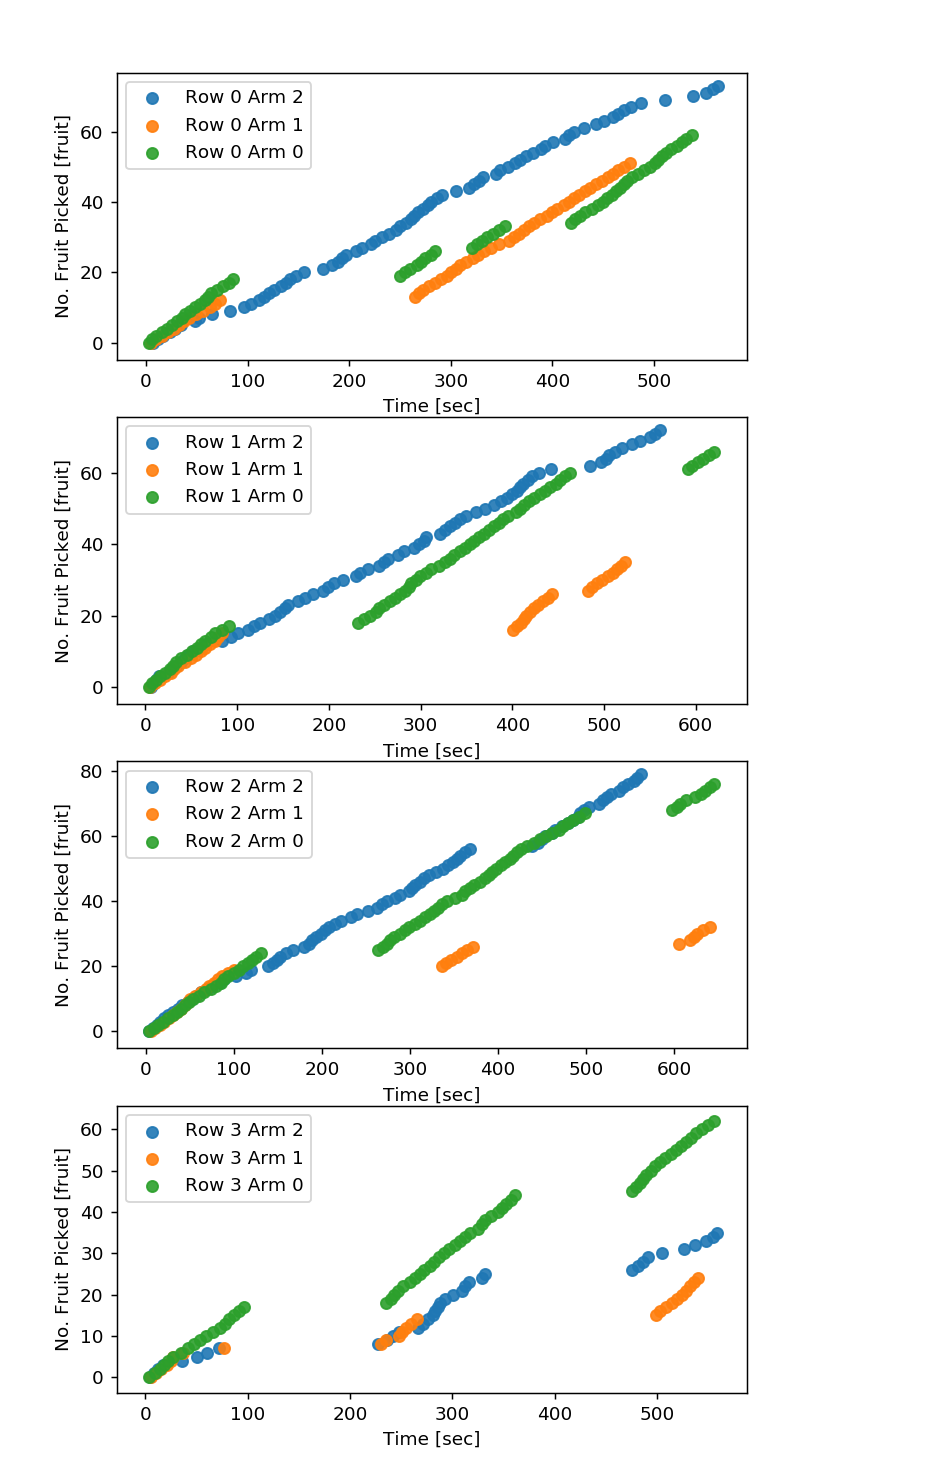

In [13]:
# Plot time versus number of fruit picked per arm
fig, ax = plt.subplots(num_row, figsize=(7, 11))

for rows in range(num_row):
    for manipulators in range((num_arms-1), -1, -1):
        time_apples = np.copy(a[rows,manipulators].pickData())
        apples      = range(np.shape(time_apples)[0])

        
        arm_label = "Row "+str(rows)+" Arm "+str(manipulators)
        
        ax[rows].scatter(time_apples, apples, alpha=0.9, label=arm_label)
        ax[rows].set_xlabel("Time [sec]")
        ax[rows].set_ylabel("No. Fruit Picked [fruit]")
#         ax[rows].set_title("No. of fruit picked versus time")
        ax[rows].legend(loc='upper left', ncol=1)
        
        fig.subplots_adjust(bottom=0.05, top=0.95, right=0.8)
        
        plt.show()
        
        

In [16]:
# analyze the % time each arm is in each state 
idle       = 0.
pickingyz  = 0.
pickingx   = 0.
grabbing   = 0.
retracting = 0.
unloading  = 0.

tot_num_arms = num_arms*num_row

state_step = 0

state_data = np.zeros((tot_num_arms, len(arm_states)))

# obtain the state for each arm
for time_step in arm_states:
    for arm_num in time_step:
        state_data[arm_num[0],state_step] = arm_num[1]
       
    state_step += 1
        
idle_arm   = 0.
pickyz_arm = 0.
pickx_arm  = 0.
grab_arm   = 0.
retr_arm   = 0.
unlo_arm   = 0.

row_n = 0
arm_n = 0

# for plotting
idle_plot   = []
pickyz_plot = []
pickx_plot  = []
grab_plot   = []
retr_plot   = []
unlo_plot   = []


# for each arm take the state obtained using state_data, determine the state at each time point for each arm 
for i in range(tot_num_arms):
    for x in state_data[i]:
        if x == 0:
            idle_arm   += 1
        elif x == 1:
            pickyz_arm += 1
        elif x == 2:
            pickx_arm  += 1
        elif x == 3:
            grab_arm   += 1
        elif x == 4:
            retr_arm   += 1
        elif x == 5:
            unlo_arm   += 1
    
    # add them all together so that percentages can be calculated
    total = idle_arm + pickyz_arm + pickx_arm + grab_arm + retr_arm + unlo_arm
    
    # get the total amount of time all arms spent in each state
    idle       += idle_arm
    pickingyz  += pickyz_arm
    pickingx   += pickx_arm
    grabbing   += grab_arm
    retracting += retr_arm
    unloading  += unlo_arm
    
    # append the current arm's data to the plotting list
    idle_plot.append(idle_arm)
    pickyz_plot.append(pickyz_arm)
    pickx_plot.append(pickx_arm)
    grab_plot.append(grab_arm)
    retr_plot.append(retr_arm)
    unlo_plot.append(unlo_arm)
    
    arm_n += 1
    
    # used to detemine which row corresponds to the specific arm
    if i%num_row == 0:
        row_n = math.floor(i/num_row)
        arm_n = 0
        
#     print("Arm", arm_n, "in row", row_n)
#     print("Idle:", idle_arm, "[unitless], Picking:", pick_arm, "[unitless], Retracting:", retr_arm, "[unitless], Unloading:", unlo_arm, "[unitless]")
#     print("Idle: {0:.4f}".format(idle_arm/total*100), "[%], Picking: {0:.4f}".format(pick_arm/total*100), "[%], Retracting: {0:.4f}".format(retr_arm/total*100), "[%], Unloading: {0:.4f}".format(unlo_arm/total*100), "[%]")
#     print("")
    
    # reset for the next run
    idle_arm   = 0.
    pickyz_arm = 0.
    pickx_arm  = 0.
    grab_arm   = 0.
    retr_arm   = 0.
    unlo_arm   = 0.


In [17]:
## Functions to add grouping into the arm state percentage plot (and other future plots)
# https://stackoverflow.com/questions/19184484/how-to-add-group-labels-for-bar-charts-in-matplotlib

def mk_groups(data):
    # function takes a dictionary (or anything with an items() method, like collections.OrderedDict) and converts it to a data format that is then used to create the chart. It is basically a list
    try:
        newdata = data.items()
    except:
        return

    thisgroup = []
    groups = []
    for key, value in newdata:
        newgroups = mk_groups(value)
        if newgroups is None:
            thisgroup.append((key, value))
        else:
            thisgroup.append((key, len(newgroups[-1])))
            if groups:
                groups = [g + n for n, g in zip(newgroups, groups)]
            else:
                groups = newgroups
    return [thisgroup] + groups

def add_line(ax, xpos, ypos):
    # creates a vertical line in the subplot at the specified positions (in axes coordinates)
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_group_bar(ax, data):
    # takes a dictionary and creates the subplot with the labels beneath
    groups = mk_groups(data)
    xy = groups.pop()
    x, y = zip(*xy)
    ly = len(y)
    xticks = range(1, ly + 2)

    ax.set_xticks(xticks)
    ax.set_xticklabels(x)
    ax.set_xlim(.5, ly + .5)

    scale = 1. / ly
    for pos in range(ly + 1):
        add_line(ax, pos * scale, -.1)
        
    ypos = -.2
    while groups:
        group = groups.pop()
        pos = 0
        for label, rpos in group:
            lxpos = (pos + .5 * rpos) * scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale, ypos)
        ypos -= .1



<IPython.core.display.Javascript object>


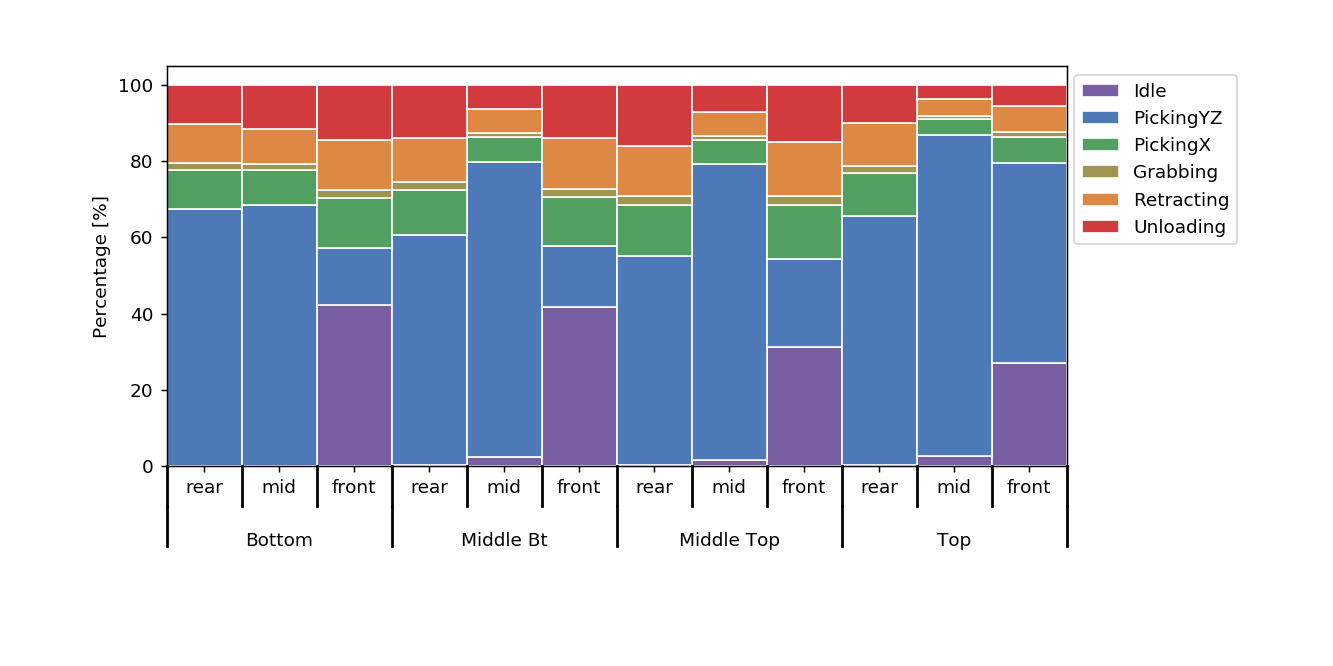

In [18]:
# % stacked bar plot
## https://chrisalbon.com/python/data_visualization/matplotlib_percentage_stacked_bar_plot/

data = {'Bottom':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Middle Bt':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Middle Top':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Top':
           {'rear':0,
            'mid':1,
            'front':2
           },
       }



# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# Set bar width at 1
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(1,len(idle_plot)+1)] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 
# print(tick_pos)

# Create the total steps per state
totals = [i+j+k+l+m+n for i,j,k,l,m,n in zip(idle_plot, pickyz_plot, pickx_plot, grab_plot, retr_plot, unlo_plot)]

# Create the percentage of the total steps for idle state
per_idle = [i / j * 100 for  i,j in zip(idle_plot, totals)]
# Create the percentage of the total steps for pickingyz state
per_pickyz = [i / j * 100 for  i,j in zip(pickyz_plot, totals)]
# Create the percentage of the total steps for pickingx state
per_pickx = [i / j * 100 for  i,j in zip(pickx_plot, totals)]
# Create the percentage of the total steps for grabbing state
per_grab = [i / j * 100 for  i,j in zip(grab_plot, totals)]
# Create the percentage of the total steps for retracting state
per_retr = [i / j * 100 for  i,j in zip(retr_plot, totals)]
# Create the percentage of the total steps for unloading state
per_unlo = [i / j * 100 for  i,j in zip(unlo_plot, totals)]

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using idle data
       per_idle, 
       # labeled 
       label='Idle', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#6B4C9A',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pickyz, 
       # with per_idle
       bottom=per_idle, 
       # labeled 
       label='PickingYZ', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#396AB1', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pickx, 
       # with per_idle
       bottom=[i+j for i,j in zip(per_idle, per_pickyz)], 
       # labeled 
       label='PickingX', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#3E9651', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_grab, 
       # with per_idle
       bottom=[i+j+k for i,j,k in zip(per_idle, per_pickyz, per_pickx)], 
       # labeled 
       label='Grabbing', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#948B3D', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_retr, 
       # with per_idle and per_pick on bottom
       bottom=[i+j+k+l for i,j,k,l in zip(per_idle, per_pickyz, per_pickx, per_grab)], 
       # labeled 
       label='Retracting',
       # with alpha
       alpha=0.9, 
       # with color
       color='#DA7C30', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_unlo, 
       # with all other percents on bottom
       bottom=[i+j+k+l+m for i,j,k,l,m in zip(per_idle, per_pickyz, per_pickx, per_grab, per_retr)], 
       # labeled 
       label='Unloading',
       # with alpha
       alpha=0.9, 
       # with color
       color='#CC2529', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )


ax.set_ylabel("Percentage [%]")

# grouping x-axis values
label_group_bar(ax, data)
f.subplots_adjust(bottom=0.3, top=0.9, right=0.8)
# f.subplots_adjust()

# rotate axis labels
# plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

# create legend outside of plot
# see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)

# shot plot
plt.show()

In [42]:
# total values 
idle_all = idle*dt
pickyz_all = pickingyz*dt
pickx_all = pickingx*dt
grab_all = grabbing*dt
retract_all = retracting*dt
unload_all = unloading*dt

# print("total time spent idle for all arms:", idle_all, "sec")
# print("total time spent picking in yz axis for all arms:", pickyz_all, "sec")
# print("total time spent picking in x axis for all arms:", pickx_all, "sec")
# print("total time spent grabbing fruit for all arms:", grab_all, "sec")
# print("total time spent retracting for all arms:", retract_all, "sec")
# print("total time spent unloading for all arms:", unload_all, "sec")

total_time = (idle_all + pickyz_all + pickx_all + grab_all + retract_all + unload_all) # / (num_arms*num_row_arms)

# print("total time all arms:", total_time, "sec") 
# print("Which totals internal simulator seconds multiplied by number of arms")

percent_idle    = (idle_all / total_time) * 100
percent_pickyz  = (pickyz_all / total_time) * 100
percent_pickx   = (pickx_all / total_time) * 100
percent_grab    = (grab_all / total_time) * 100
percent_retract = (retract_all / total_time) * 100
percent_unload  = (unload_all / total_time) * 100

print("For all arms:")
print("Total percent time idle:             {0:.2f}".format(percent_idle), "%")
print("Total percent picking fruit          {0:.2f}".format(percent_pickyz+percent_pickx+percent_grab), "%")
print("---------------------------------------------")
print("Picking fruit is broken up into:")
print("Total percent time picking in y, z:  {0:.2f}".format(percent_pickyz), "%")
print("Total percent time picking in x:      {0:.2f}".format(percent_pickx), "%")
print("Total percent time grabbing fruit     {0:.2f}".format(percent_grab), "%")
print("---------------------------------------------")
print("Total percent time retracting        {0:.2f}".format(percent_retract), "%")
print("Total percent time unloading         {0:.2f}".format(percent_unload), "%")


For all arms:
Total percent time idle:             12.45 %
Total percent picking fruit          66.93 %
---------------------------------------------
Picking fruit is broken up into:
Total percent time picking in y, z:  55.21 %
Total percent time picking in x:      9.98 %
Total percent time grabbing fruit     1.74 %
---------------------------------------------
Total percent time retracting        10.02 %
Total percent time unloading         10.60 %


In [31]:
# Calculate how many goals wer given to each arm and how many of those were reached
for rows in range(num_row):
    for count in range(num_arms):
        given = a[rows, count].goals_given
        reached = a[rows, count].reached_goals
        percent_reached = (reached / given) * 100
        
        print("For arm", count, "row", rows)
        print("Number of goals given:", given, "number of goals reached:", reached)
        print("Percent reached goals: {0:.2f}".format(percent_reached), "%")
        print("")

For arm 0 row 0
Number of goals given: 83 number of goals reached: 60
Percent reached goals: 72.29 %

For arm 1 row 0
Number of goals given: 86 number of goals reached: 52
Percent reached goals: 60.47 %

For arm 2 row 0
Number of goals given: 86 number of goals reached: 74
Percent reached goals: 86.05 %

For arm 0 row 1
Number of goals given: 92 number of goals reached: 67
Percent reached goals: 72.83 %

For arm 1 row 1
Number of goals given: 89 number of goals reached: 36
Percent reached goals: 40.45 %

For arm 2 row 1
Number of goals given: 83 number of goals reached: 73
Percent reached goals: 87.95 %

For arm 0 row 2
Number of goals given: 105 number of goals reached: 77
Percent reached goals: 73.33 %

For arm 1 row 2
Number of goals given: 103 number of goals reached: 33
Percent reached goals: 32.04 %

For arm 2 row 2
Number of goals given: 95 number of goals reached: 80
Percent reached goals: 84.21 %

For arm 0 row 3
Number of goals given: 89 number of goals reached: 63
Percent re

num runs 65001


<IPython.core.display.Javascript object>


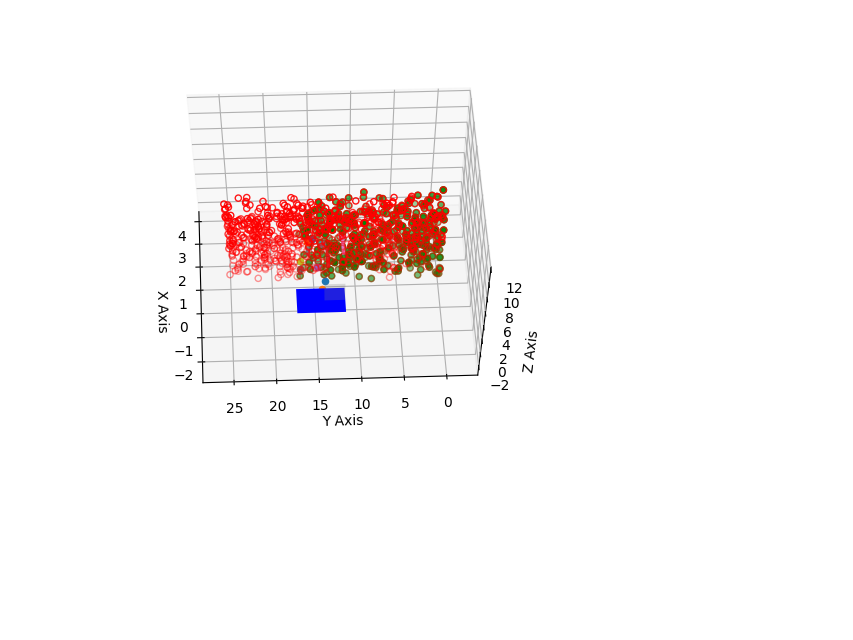

KeyboardInterrupt: 

In [21]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 60 == 0:
        ax.clear()
        
        for rows in range(num_row):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current time value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)
    
        # draw cyliders for the extending arms
        for rows in range(num_row):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])
                # need to switch this to a cylinder
                xc, yc, zc = dr.drawArmCylinder(a[rows,count].qay[run], a[rows,count].qaz[run], a[rows,count].q_f[0], a[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(fruit_row_ed-3, fruit_row_tk+3)
        ax.set_zlim(fruit_row_bt-3, fruit_row_tp+3)
        
        ax.set_ylim(fruit_row_st-3, fruit_row_end+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
fig.show()



In [30]:
# need to print all the fruit that remains unpicked
miss  = 0
sched = 0 
pick  = 0

# prints all the fruit that has not been picked
for x in range(len(fruit.sortedFruit[1])):
    if fruit.sortedFruit[:,x][3] == 0: 
        miss += 1
#         print(x)
    elif fruit.sortedFruit[:,x][3] == 1:
        sched += 1
#         print(x)
    elif fruit.sortedFruit[:,x][3] == 2:
        pick += 1
        
# should plot the three different groups to see where they are
print("Total missed fruit:", miss)
print("Total scheduled, but not picked fruit:", sched)
print("Total picked fruit:", pick)

print("")
print("They add up to:", miss+sched+pick)
print("Total unpicked fruit:", miss+sched)

per = 100* (miss+sched) / (miss+sched+pick)

print("Percent missed fruit: {0:.2f}".format(per), "%")

Total missed fruit: 118
Total scheduled, but not picked fruit: 114
Total picked fruit: 668

They add up to: 900
Total unpicked fruit: 232
Percent missed fruit: 25.78 %
